# A journey into the Reddit network - Hyperlink formation -

The goal of the project is to explore the Reddit hyperlink network and in particular to assess if the balance and the status theories can be applied on this dataset. Also, we examine if the network exhibits locally the same behavior as the whole network. We will use the embedding vectors of the subreddits to group them into clusters, and check if the balance theory prevails over the status one inside these clusters. Also, the dominant theory might be cluster dependent. One final important aspect is the temporal dimension of the network. We propose to analyse the evolution of the network looking at the proportion of new positive edges in clusters and also by identifying subreddits participating to conflicts.

Nota Bene: You will find pre-computed datasets in the [Google drive](https://drive.google.com/drive/folders/1uuguQWxG2Ks8sy-hwCxebEWnP5TehhJw?usp=sharing).

# Table of contents
<a id = table_of_contents></a>
1. [Load the data](#load_data)

2. [Some statistics of the graph](#some_statistics)

3. [At a global scale](#global_scale)
    - [Presentation of the function used](#global_functions)
    - [Balance theory](#global_balance)
    - [Status theory](#global_status)
    - [What is wrong with these theories ?](#global_new_improv)
    - [GLM models for balance and status](#global_glm)
  
 
4. [At a local scale: clustering analysis](#local_clustering)
    - [Grouping the subreddits into categories](#local_build)
    - [Cluster analysis: building the dataset](#local_build_dataset)
    - [Cluster analysis: Intercluster interactions](#local_inter_relations)
    - [Cluster analysis: cluter connectivity](#local_connectivity)
    - [Cluster analysis: Balance theory](#local_balance)
    - [Cluster analysis: Status theory](#local_status)
 

5. [An evolution through time: temporal analysis](#temporal)
    - [Checking the trend](#temporal_trend)
    - [Aside: bokeh](#temporal_bokeh)
    - [Finding conflicts](#temporal_conflicts)

  

6. [Conclusion](#conclusion)

Here are a few libraries that we will need in order to analyse the network of Reddit hyperlink. Also, we provide an python file called _helper_functions.py_, that provides the functions used for plotting the results for the clustering part. All the functions used for computing the triad census are explained in this jupyter notebook. They are also included in the python file, so that one can execute the cells related to the clustering part (_at a local scale_) independently of the _global scale_ part.

In [70]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
import networkx as nx
import itertools

import random
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import mixture
import matplotlib as mpl
from helper_functions import * 
import helper_functions
import statsmodels.api as sm
import seaborn as sns

import pickle 
from openTSNE import TSNE # we use the openTSNE package because the sklearn version is much too slow

import warnings
warnings.filterwarnings('ignore')

## Load data
<a id = load_data></a>

We propose to use the reddit dataset (which can be found here: https://snap.stanford.edu/data/soc-RedditHyperlinks.html). This dataset contains the hyperlink  network representing the connection between subreddits, from January 2014 to April 2017. This network could be though of as a multigraph where the nodes represent different subreddits, and each edge corresponds to a hyperlink between subreddits appearing in each post. Also, this graph has a temporal dimension that keeps track of the date at which each hyperlink was created. Furthermore the multigraph is directed and signed, where the signs were assigned through binary sentimental analysis, and thus take value in {-1,+1}. 
Therefore, there might be muliple parallel edges between the any two nodes, each with a unique timestamp and in total there are 67180 nodes and 858488 signed edges. 

Another complementary dataset of the reddit hyperlink network can be found at http://snap.stanford.edu/data/web-RedditEmbeddings.html. It has the embedding vectors for each subreddit. The embedding vectors are of dimensionality 300, and there is a total of 51278 vectors (so we might exclude some subreddits in the analysis).

Here are the datafiles that we will need. We have three files, two containing the Reddit hyperlink networks that are are associated with the title and the body of the post respectively, and a third containing the embeddings assigned to each subreddit.

In [71]:
# change here the directory
data_dir = "./data/" 
pickle_dir = "./pickle/"

# the columns to load
columns = ["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT",
           "POST_ID", "TIMESTAMP", "LINK_SENTIMENT"]

In [3]:
# load data
reddit_title = pd.read_csv(data_dir+"soc-redditHyperlinks-title.tsv", sep="\t", usecols=columns).astype(
    {"SOURCE_SUBREDDIT": "category", "TARGET_SUBREDDIT": "category", "POST_ID": "category"})
reddit_title.TIMESTAMP = pd.to_datetime(reddit_title.TIMESTAMP)
reddit_body = pd.read_csv(data_dir+"soc-redditHyperlinks-body.tsv", sep="\t", usecols=columns).astype(
    {"SOURCE_SUBREDDIT": "category", "TARGET_SUBREDDIT": "category", "POST_ID": "category"})
reddit_body.TIMESTAMP = pd.to_datetime(reddit_body.TIMESTAMP)

# load embedding
embedding_raw=pd.read_csv(data_dir+"web-redditEmbeddings-subreddits.csv", sep=",",header=None,names=[i for i in range(300)],index_col=0)

We combine the networks of hyperlinks in the title and the body into a unique dataframe, and also give for each edge (i.e. hyperlink) an 'id', which depends on the name of the source subreddit, the target one, and the id of the post (since there can be multiple hyperlinks to the same subreddit from a particular subreddit).

In [4]:
combined=pd.concat([reddit_title,reddit_body],ignore_index=True).sort_values("TIMESTAMP").reset_index(drop=True)
answer=["NO","YES"]
print("Does the first 3 columns uniquely identify the rows?",answer[combined.set_index(["SOURCE_SUBREDDIT","TARGET_SUBREDDIT","POST_ID"]).index.is_unique])
combined["id"]=combined.SOURCE_SUBREDDIT+combined.TARGET_SUBREDDIT+combined.POST_ID
print("Do we have loop of a node towards it self?",answer[1 if len(combined[combined.SOURCE_SUBREDDIT==combined.TARGET_SUBREDDIT])>0 else 0])
combined

uniqueNode= combined.SOURCE_SUBREDDIT.append(combined.TARGET_SUBREDDIT).unique()
embedding= embedding_raw[embedding_raw.index.isin(uniqueNode)].reset_index()

Does the first 3 columns uniquely identify the rows? YES
Do we have loop of a node towards it self? NO


We might also check if the indices for the embeddings are unique, which is indeed the case here.

In [5]:
print("Is index unique?",answer[embedding_raw.index.is_unique])
embedding_raw

Is index unique? YES


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
spiders,0.158972,0.285813,0.226329,-0.183338,-0.163159,-0.188910,0.422705,0.168602,0.178193,-0.149062,...,-0.025041,0.184655,0.111942,-1.125799,0.223129,-0.387323,-0.234882,-0.252297,-0.054315,0.500009
askreddit,-0.499114,0.323983,-0.424809,-0.222705,-0.327201,0.412856,1.040088,0.996697,-1.256240,-0.595798,...,0.072151,0.226658,0.535705,0.039861,-0.027087,-0.239952,0.554510,0.676439,-0.328846,0.941547
globaloffensivetrade,-0.023145,-1.199374,1.661484,-1.025296,1.424670,-1.179507,-1.035703,0.329301,-0.567272,0.504787,...,2.998430,-1.235703,-0.326850,4.381238,-1.965378,-2.369674,-0.615389,2.010601,-0.919314,-2.149625
fireteams,2.492506,-2.529917,-0.448484,-3.543441,-0.586122,-0.101517,1.837567,-0.215715,-2.460388,0.487192,...,-1.875214,0.969291,0.497958,2.941132,2.423561,1.315691,-0.959618,0.151845,-0.852492,-0.467526
funny,-0.819370,-0.865261,0.301753,0.018787,0.201029,0.070462,0.903895,1.038460,-0.306950,-0.809457,...,1.364194,0.830233,-0.137822,-2.204667,-0.162008,0.390291,-0.556404,0.322684,0.641634,1.320716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33rd,-0.000076,-0.001643,-0.002896,0.000581,-0.003509,-0.000827,0.002095,0.000123,0.004370,-0.002224,...,-0.001570,-0.002246,0.003491,-0.004310,0.001598,0.005168,-0.001156,0.001575,-0.001938,0.001594
bestofvic2015,-0.000203,0.012698,-0.007575,0.006486,-0.001693,0.004743,-0.002401,0.000121,0.001600,-0.005140,...,0.001392,0.001258,0.002970,-0.014106,-0.002713,-0.008648,0.003660,-0.005755,-0.001790,-0.001313
aberystwyth,-0.001563,0.004733,-0.000082,-0.000982,-0.001511,0.001285,0.002187,0.002967,0.000660,-0.006815,...,0.002213,0.000520,-0.000564,-0.010018,0.002507,-0.000651,0.004169,-0.004672,0.002371,0.001073
mail_forwarding,0.009269,0.024779,-0.017018,-0.007228,0.002351,0.003462,-0.008446,0.004544,0.022505,-0.013016,...,-0.002591,0.003482,0.001042,-0.002796,0.010739,-0.009148,0.000363,-0.003144,0.001945,-0.017272


Now we would like to check if the theories of balance and status apply to this network, as developped in the paper *Signed Networks in Social Media* (Jure Leskovec, Daniel Hunttenlocher, Jon Kleinberg). 

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***
## Some statistics about the Reddit hyperlink network
<a id = some_statistics></a>

In this section, we compute some basic quantities of the SubReddit graph, such as the proportion of positive and negative edges, the number of created edges per week, etc.

In [7]:
nb_positive_edges = len(combined[combined.LINK_SENTIMENT == 1].index)
nb_negative_edges = len(combined[combined.LINK_SENTIMENT == -1].index)
total = nb_positive_edges + nb_negative_edges
print("All edges are positive or negative: {}".format(answer[total == len(combined.index)]))
print("Total number of positive edges: {} (proportion: {:.3f})".format(nb_positive_edges, nb_positive_edges/total))
print("Total number of negative edges: {} (proportion: {:.3f})".format(nb_negative_edges, nb_negative_edges/total))

All edges are positive or negative: YES
Total number of positive edges: 776278 (proportion: 0.904)
Total number of negative edges: 82210 (proportion: 0.096)


As we can see, a huge majority of the edges are positive.

Now, we count the number of edges that are created each week in the time period.

In [8]:
daily_grouped = combined.groupby([pd.Grouper(key='TIMESTAMP', freq='W')]).LINK_SENTIMENT.agg([('NEGATIVE' , lambda x : x[x < 0].sum()) , ('POSITIVE' , lambda x : x[x > 0].sum())])
daily_grouped.NEGATIVE = np.abs(daily_grouped.NEGATIVE)
daily_grouped['PROP_POSITIVE'] = daily_grouped.POSITIVE / (daily_grouped.NEGATIVE + daily_grouped.POSITIVE)

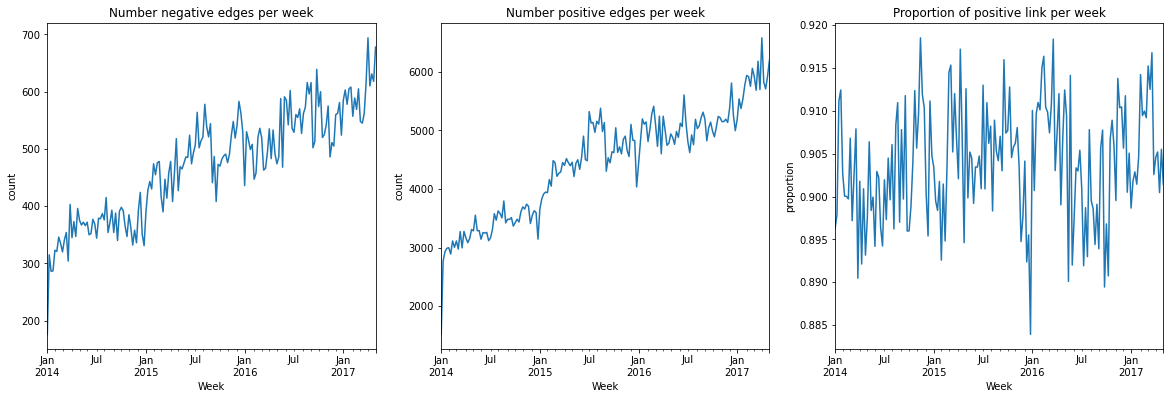

In [9]:
fig, axs = plt.subplots(1,3,figsize=(20, 6))
# daily_grouped.plot(kind='bar', rot=0, ax=axs)
daily_grouped.NEGATIVE.plot(ax=axs[0])
daily_grouped.POSITIVE.plot(ax=axs[1])
daily_grouped.PROP_POSITIVE.plot(ax=axs[2])
axs[0].set_xlabel("Week")
axs[1].set_xlabel("Week")
axs[2].set_xlabel("Week")
axs[0].set_ylabel("count")
axs[1].set_ylabel("count")
axs[2].set_ylabel("proportion")
axs[0].set_title("Number negative edges per week")
axs[1].set_title("Number positive edges per week")
axs[2].set_title("Proportion of positive link per week")
plt.show()

Over the 3 years, the number of hyperlinks created per week has nearly doubled, but the relative proportion of positive hyperlinks stayed quite constant across the time, not showing any particular trend in time. Some periods during these three years have a larger proportion of negative edges created, in particular during December 2015 or October 2016, and it can interesting to see if these events had an impact on the number of triads, as well as on the repartition of the type of triads.

In [10]:
mean_prop = daily_grouped.PROP_POSITIVE.mean()
var_prop = daily_grouped.PROP_POSITIVE.var()
print("Mean proportion of positive edges created in a week: {:.4f}".format(mean_prop))

Mean proportion of positive edges created in a week: 0.9039


In [11]:
print("Approximated 95% range: [{:.4f},{:.4f}]".format(mean_prop-2*np.sqrt(var_prop), mean_prop+2*np.sqrt(var_prop)))

Approximated 95% range: [0.8904,0.9174]


Here are just a few weeks with major deviation in the number of new edges created for one or another type of edge:

In [12]:
positive_strong_pics = daily_grouped[daily_grouped.PROP_POSITIVE > mean_prop+2*np.sqrt(var_prop)] 
negative_strong_pics = daily_grouped[daily_grouped.PROP_POSITIVE < mean_prop-2*np.sqrt(var_prop)]

In [13]:
positive_strong_pics

,NEGATIVE,POSITIVE,PROP_POSITIVE
TIMESTAMP,,,
2014-11-16,332,3743,0.918528
2016-03-20,466,5244,0.918389


In [14]:
negative_strong_pics

,NEGATIVE,POSITIVE,PROP_POSITIVE
TIMESTAMP,,,
2015-12-27,530,4036,0.883925
2016-05-15,588,4763,0.890114
2016-09-25,639,5141,0.889446


<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***
## At a global scale...
<a id = global_scale></a>

In this section, we are interested in the link properties of the whole network. For example, is it true (on average) that the friend of my friend is my friend. More formally, does a positive hyperlink between two subreddit A and C, and another positive link between C and B, will imply a positive link between A and B ? We will explain more in depth how we will test these hypothesis.

### Presentation of the functions used for checking the balance and status theories
<a id = global_functions></a>

Before doing our analysis, we must ensure that the network does not have too many edges between two nodes. In particular, we will use the following functions to select the duplicated edges so as to have the most meaningful graph representation. 

In [15]:
def same_value(s):
    """Check if an array has an unique value"""
    a = s.to_numpy()
    return (a[0] == a).all()


def selectLastEdge(df):
    # use numpy array as concat is much faster-> then we explode the dataframe to have all of them
    # if only one observation
    if df.shape[0] == 1:
        return df.head(1).id.to_numpy()
    # if all values are the same
    if same_value(df.LINK_SENTIMENT):
        return df.head(1).id.to_numpy()
    # +- or -+ (signs are different)
    if df.shape[0] == 2:
        return df.tail(1).id.to_numpy()

    # othewise we compute the median delta time (-> estimates the freq. at which edges appear)
    median_deltatime = (df.TIMESTAMP.shift(-1)-df.TIMESTAMP).median()
    start, end = (df.TIMESTAMP.tail(1)-median_deltatime).item(), df.TIMESTAMP.tail(1).item()
    nb_signs = df.query(
        '@start <= TIMESTAMP <= @end').LINK_SENTIMENT.value_counts()
    # if we have a tie, we look what is the dominant sign in the last observation
    if len(nb_signs) > 1 and same_value(nb_signs):
        # moving avg from the end (consider only odd positions)
        # e.g. ++--+- -> -1,0,-1,-2,... -> 0,-2
        sign_avg = df.LINK_SENTIMENT.sort_index(ascending=False).cumsum()[1::2]
        if all(sign_avg == 0):  # +-+-+-+-+- or -+-+-+-+
            return df.tail(1).id.to_numpy()
        else:
            # search for the first negative or positive negative occurrence in sign_avg
            # then if this is positive assign -> +1 otherwise -> -1
            sign = 1 if sign_avg[(sign_avg != 0).idxmax()] > 0 else -1
    else:
        # take the dominant sign in the time interval
        sign = nb_signs.idxmax()

    # find the last group with the corresponding sign
    # here we first take the first occurrence of each group and sort them in decreasing order (wrt. the dates)
    firstOccurenceReverse = df.groupby([(df.LINK_SENTIMENT != df.LINK_SENTIMENT.shift(
    )).cumsum()]).head(1).sort_index(ascending=False)
    # the we filter by the signs and take the first occurrence
    return firstOccurenceReverse[firstOccurenceReverse.LINK_SENTIMENT == sign].head(1).id.to_numpy()


In [7]:
# labels that we use for the columns
columns_balance = ["t3B", "t0B", "t12B"]
columns_balance_full = ["t3B", "t1B", "t2B", "t0B"]
columns_status = ["t"+str(i+1) for i in range(16)]

As this process can take some time to compute, you can find and load a pre-computed version:

In [6]:
# if already computed, otherwise skip this cell
last_network = pd.read_pickle(pickle_dir+"last_network.pkl")
dataset = pd.read_pickle(pickle_dir+"triad_last_network.pkl")

Otherwise, here is how we compute it:

In [16]:
# Create and register a new `tqdm` instance with `pandas`
tqdm.pandas()

# Groupby preserves the order of rows within each group.
# combined is sorted by dates before -> this is still true in the groups
last_network_id = combined.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"], sort=False).progress_apply(
    lambda x: selectLastEdge(x)).explode().reset_index(drop=True)
last_network = combined[combined.id.isin(last_network_id)]

100%|██████████| 339643/339643 [02:28<00:00, 2284.13it/s]


Now here is the set of functions that we will use in order to compute the number of triads in the network.

In [20]:
def baseline(df):
    """Compute generative and receptive baseline"""
    gen = ((df.groupby(by="SOURCE_SUBREDDIT").mean()+1)/2.0).squeeze()
    rec = ((df.groupby(by="TARGET_SUBREDDIT").mean()+1)/2.0).squeeze()
    outdegree = df.groupby(by="SOURCE_SUBREDDIT").apply(len)
    indegree = df.groupby(by="TARGET_SUBREDDIT").apply(len)
    return gen.to_dict(), rec.to_dict(), outdegree.to_dict(), indegree.to_dict()


# open issue https://github.com/scipy/scipy/issues/12495
def convert_to_64bit_indices(A):
    A.indptr = np.array(A.indptr, copy=False, dtype=np.int64)
    A.indices = np.array(A.indices, copy=False, dtype=np.int64)
    return A


def compute_trace(A, B, C):
    """Compute tr(A*B*C) where A,B,C are sparse matrices"""
    # function defined in the first part
    A2 = convert_to_64bit_indices(A.dot(B))
    # equivalent to tr(A*B*C) but much faster...
    return A2.multiply(C.transpose()).sum()


def createGraph(df):
    """create a networkx oriented graph from a pandas dataframe"""
    G = nx.from_pandas_edgelist(df, source='SOURCE_SUBREDDIT',
                                target='TARGET_SUBREDDIT', edge_attr=None, create_using=nx.DiGraph())
    return G


def total_triad(df):
    """Count the total number of triad"""
    G = createGraph(df)
    B = nx.adjacency_matrix(G)
    A = B+B.T
    return int(compute_trace(A, A, A)/6)


def get_one_hot(targets, nb_classes):
    """Convert targerts to one-hot encoding"""
    res = np.eye(nb_classes, dtype=np.int32)[
        np.array(targets, dtype=np.int32).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])


def common_neighbors(G, u, v):
    """Find nodes that are linked to u and v in the graph G"""
    return (w for w in set(G.predecessors(u)).union(set(G.successors(u))) if w in set(G.predecessors(v)).union(set(G.successors(v))) and w not in (u, v))


def buildCovariate_quadrant(quadrant, wAC, wBC, *args, **kwargs):
    """
     1  2 |  3  4 
     5  6 |  7  8 
     ------------
     9 10 | 11 12
    13 14 | 15 16
    update one of the 4 quadrants

    parameters:
    quadrant: either 1/3/9/11
    wAC: weight of AC (or CA) edge
    wBC: weight of BC (or CB) edge

    returns the features of the given triad (e.g. nodes, type (t1,t2,...), indegree of B, outdegree of A)
    """
    if wAC == 1:
        if wBC == 1:
            case = quadrant
            return buildCovariate_status(case=case, *args, **kwargs)
        else:
            case = quadrant+1
            return buildCovariate_status(case=case, *args, **kwargs)
    else:
        if wBC == 1:
            case = quadrant+4
            return buildCovariate_status(case=case, *args, **kwargs)
        else:
            case = quadrant+5
            return buildCovariate_status(case=case, *args, **kwargs)


def buildCovariate_status(case, wAB, outdegree, indegree, gen_baseline, rec_baseline, nodeA, nodeB, nodeC, timestamp, **kwargs):
    return ( [wAB, outdegree, indegree, gen_baseline,
            rec_baseline, nodeA, nodeB, nodeC, timestamp] + 
            get_one_hot(np.array([case-1]), 16).squeeze().tolist() )


def buildDataset(df, baselines_gen, baselines_rec, outdegree, indegree):
    """
    returns:
    large data set of triads with these columns:
    "y", "outdegree", "indegree", "generative_baseline",
    "receptive_baseline", "nodeA", "nodeB", "nodeC",
    "timestamp"
    """
    # create the graph and estimate the total number of triad to pre-allocate memory.
    # also checks that the number of enumerate triads is the correct one
    G = createGraph(df)
    outdegrees = nx.out_degree_centrality(G)
    # faster to collect the results in a numpy array (we will then convert it to a dataframe)
    data = np.zeros((total_triad(df), 25))

    # create directed graph
    uniqueNode = df.SOURCE_SUBREDDIT.append(df.TARGET_SUBREDDIT).unique()
    index = {node: i for i, node in enumerate(uniqueNode)}
    # create a dictionary mapping an index to each subreddit(node) 
    node_dictionary = {i: node for i, node in enumerate(uniqueNode)}
    # create an empty graph. We will add iteratively an edge to it and count the triad that are created
    G = nx.DiGraph()
    G.add_nodes_from(uniqueNode)
    i = 0
    # iteration over the edges (sorted by dates)
    for row in tqdm(df.itertuples(), total=df.shape[0]):
        G.add_edge(row.SOURCE_SUBREDDIT, row.TARGET_SUBREDDIT,
                   weight=row.LINK_SENTIMENT)
        A, B = row.SOURCE_SUBREDDIT, row.TARGET_SUBREDDIT
        wAB = row.LINK_SENTIMENT
        baseline_node_A = baselines_gen[A]
        baseline_node_B = baselines_rec[B]

        outdegreeA = outdegree[A] if outdegree is not None else 1
        indegreeB = indegree[B] if indegree is not None else 1
        params = {"wAB": (wAB + 1)/2, "gen_baseline": baseline_node_A,
                "rec_baseline": baseline_node_B, "outdegree": outdegreeA,
                "indegree": indegreeB, "nodeA": index[A], "nodeB": index[B],
                "timestamp": row.TIMESTAMP.to_numpy()}
        # iteration over the nodes that are linked to A and B
        # form a contextualised link (edge AB come after AC and BC)
        for C in common_neighbors(G, row.SOURCE_SUBREDDIT, row.TARGET_SUBREDDIT):
            # translate to integer
            params["nodeC"] = index[C]
            # add the triad to the dataset
            if G.has_edge(A, C):
                if G.has_edge(B, C):
                    data[i] = buildCovariate_quadrant(quadrant=3, wAC=G.get_edge_data(
                        A, C)["weight"], wBC=G.get_edge_data(B, C)["weight"], **params)
                    i += 1
                if G.has_edge(C, B):
                    data[i] = buildCovariate_quadrant(quadrant=1, wAC=G.get_edge_data(
                        A, C)["weight"], wBC=G.get_edge_data(C, B)["weight"], **params)
                    i += 1
            if G.has_edge(C, A):
                if G.has_edge(B, C):
                    data[i] = buildCovariate_quadrant(quadrant=11, wAC=G.get_edge_data(
                        C, A)["weight"], wBC=G.get_edge_data(B, C)["weight"], **params)
                    i += 1
                if G.has_edge(C, B):
                    data[i] = buildCovariate_quadrant(quadrant=9, wAC=G.get_edge_data(
                        C, A)["weight"], wBC=G.get_edge_data(C, B)["weight"], **params)
                    i += 1
    # convert to a dataframe 
    dataSet = pd.DataFrame(data, columns=["y", "outdegree", "indegree", "generative_baseline",
                                        "receptive_baseline", "nodeA", "nodeB", "nodeC",
                                        "timestamp"]+["t"+str(i+1) for i in range(16)])
    # use the right format
    dataSet.timestamp = pd.to_datetime(dataSet.timestamp)
    cols = ["nodeA", "nodeB", "nodeC"]

    # translate the integer to a string (we could not store strings in the numpy array)
    def translateIndex(row):
        return node_dictionary[row]
    
    dataSet[cols] = dataSet[cols].applymap(translateIndex)
    return dataSet.sort_values("timestamp")

Here we compute the generative and receptive baseline, using the function *baseline*.

In [8]:
# we compute the generative baseline, the receptive baseline as dictionary
# we also compute the outdegree and the indegree of each node
baseline_gen, baseline_rec, outdegree, indegree = baseline(last_network)

Then, we build the dataset that we will be using for the rest of the analysis. As for *last_newtork*, the dataset is saved in a pickle file, but one can execute the following cell in order to recompute it (it can take around 10 minutes).
It is also the most efficient way to store the result in order to re-use them when working with the clusters below (we do the computation once).

In [19]:
dataset = buildDataset(last_network, baseline_gen,
                       baseline_rec, outdegree, indegree)
# compute the probability with the logit link function
dataset["p"] = np.log(np.maximum(dataset["generative_baseline"],
                                 1e-10)/np.maximum(1-dataset["generative_baseline"], 1e-10))
dataset["r"] = np.log(np.maximum(dataset["receptive_baseline"],
                                 1e-10)/np.maximum(1-dataset["receptive_baseline"], 1e-10))
dataset


100%|██████████| 339643/339643 [12:58<00:00, 436.45it/s] 


,y,outdegree,indegree,generative_baseline,receptive_baseline,nodeA,nodeB,nodeC,timestamp,t1,...,t9,t10,t11,t12,t13,t14,t15,t16,p,r
0,1.0,32.0,6.0,0.9375,1.000000,corejerk,bestof2013,posthardcore,2014-01-01 04:58:04,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.708050,23.025851
1,1.0,32.0,6.0,0.9375,1.000000,corejerk,bestof2013,posthardcore,2014-01-01 04:58:04,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.708050,23.025851
2,1.0,32.0,6.0,0.9375,1.000000,corejerk,bestof2013,metalcore,2014-01-01 04:58:04,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.708050,23.025851
3,1.0,32.0,6.0,0.9375,1.000000,corejerk,bestof2013,metalcore,2014-01-01 04:58:04,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.708050,23.025851
4,1.0,4.0,151.0,1.0000,0.960265,mlpccg,mylittlepony,mlptcg,2014-01-02 03:03:26,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.025851,3.184974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077306,1.0,145.0,124.0,1.0000,0.854839,brasilonreddit,bad_cop_no_donut,nottheonion,2017-04-30 16:47:50,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.025851,1.773067
4077305,1.0,145.0,124.0,1.0000,0.854839,brasilonreddit,bad_cop_no_donut,nottheonion,2017-04-30 16:47:50,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.025851,1.773067
4077335,1.0,145.0,127.0,1.0000,0.874016,brasilonreddit,roadcam,publicfreakout,2017-04-30 16:47:50,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.025851,1.936941
4077319,1.0,145.0,124.0,1.0000,0.854839,brasilonreddit,bad_cop_no_donut,nostupidquestions,2017-04-30 16:47:50,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.025851,1.773067


This dataset is used both for the status and the balance analysis. Here is a function to build the columns that we will use for checking the balance theory:

In [22]:
# classify the categories from status to the corresponding ones in balance
def buildBalanceCategory(dataset):
    # Let _/_/_ be the sign of the corresponding edges AB/BC/AC

    # correspond to ?/+/+
    dataset["t3B"] = dataset.t1+dataset.t3+dataset.t9+dataset.t11
    # correspond to ?/+/-
    dataset["t2B"] = dataset.t5+dataset.t7+dataset.t13+dataset.t15
    # correspond to ?/-/+
    dataset["t1B"] = dataset.t2+dataset.t4+dataset.t10+dataset.t12
    dataset["t12B"] = dataset["t1B"]+dataset["t2B"]
    # correspond to ?/-/-
    dataset["t0B"] = dataset.t6+dataset.t8+dataset.t14+dataset.t16

buildBalanceCategory(dataset)

If you want to save the *last_network* and *dataset* variables in a pickle file: 

In [21]:
# Uncomment to store the data:
# last_network.to_pickle(pickle_dir+"last_network.pkl")
# dataset.to_pickle(pickle_dir+"triad_last_network.pkl")

Through our analysis, we will compare the results obtained on the Reddit network to its shuffled version. Thus, we again build the dataset for the shuffled network. Note that, as before, a pre-computed version is available and can be directly loaded.

In [9]:
shuffled = pd.read_pickle(pickle_dir+"shuffled.pkl")
dataset_shuffled = pd.read_pickle(pickle_dir+"triad_shuffled.pkl")

Otherwise, uncomment to re-compute it:

In [24]:
# # Create a shuffled version
# shuffled = last_network.copy().reset_index(drop=True)
# # random sign (keeping the same fraction of positive edges)
# shuffled.LINK_SENTIMENT = shuffled.LINK_SENTIMENT.sample(
#     frac=1).reset_index(drop=True)

# dataset_shuffled = buildDataset(shuffled, *baseline(shuffled))
# dataset_shuffled["p"] = np.log(np.maximum(dataset_shuffled["generative_baseline"],
#                                           1e-10)/np.maximum(1-dataset_shuffled["generative_baseline"], 1e-10))
# dataset_shuffled["r"] = np.log(np.maximum(dataset_shuffled["receptive_baseline"],
#                                           1e-10)/np.maximum(1-dataset_shuffled["receptive_baseline"], 1e-10))
# buildBalanceCategory(dataset_shuffled)
# dataset_shuffled

Uncomment to save it:

In [25]:
# shuffled.to_pickle(pickle_dir+"shuffled.pkl")
# dataset_shuffled.to_pickle(pickle_dir+"triad_shuffled.pkl")

Now that all the datasets are compute, we can run the analysis for the balance theory and status. We use the following functions to compute the number of triads, as well as the surprise, relative to the shuffled dataset.

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
### Balance theory
<a id = global_balance></a>

We begin our analysis with the balance theory, introduced by Heider in the 1940s. By counting the number of triad of each type in an directed signed network, the theory seeks to confirm the tendency for some type of triad to appear more often than the others. In particular, the type of triad with only positive edges or only one positive edges, which are called *balanced*, should be more represented than the two other triads, with two positive edges or only negative edges (called *unbalanced*). This theory can be extended to the *weak structural balance* theory, by allowing triad with only negative edges not to be underrepresented, as introduced by Davis in the 1960s.

In [26]:
def compute_triad(dataset, normalisation=False):
    # classify the triads using the sign of the last edge (AB)
    # (the sign of AB belongs to {0,1})
    # t3B + AB=1 => +++
    # t2B + AB=0 or t0B + AB=1 or t1B + AB=0 => +--
    # t2B + AB=1 or t3B + AB=0 or t1B + AB=1 => ++-
    # t0B + AB=0 => ---
    balance_columns = dataset[columns_balance_full]
    if normalisation:
        balance_columns = balance_columns/dataset.outdegree[:, None]
    # multiply the indicator columns be the sign of AB, then sum over all the rows 
    # (we obtain the number of triads in each category)
    separated_counts = pd.concat((balance_columns*dataset.y[:, None], balance_columns*(
        1-dataset.y[:, None])), axis=1).sum(axis=0).reset_index(drop=True)
    retVal = []
    # combine the columns using the rules defined above
    for l in [[0], [3, 5, 6], [1, 2, 4], [7]]:
        tot_per_cat = 0
        for i in l:
            tot_per_cat += separated_counts[i]
        retVal.append(tot_per_cat)
    total = separated_counts.sum()
    # convert to a pandas dataframe
    table = pd.Series(retVal).to_frame("Triad")
    table = table.rename(index={0: '+++', 1: "+--", 2: "++-", 3: "---"})
    table["p(T)"] = table.Triad/total
    return table, total


def surprise_balance(table, total):
    """Compute the surprise as defined in the article"""
    table["s(T)"] = (table["Triad"]-total*table["p_0(T)"]) / \
        np.sqrt(total*table["p_0(T)"]*(1-table["p_0(T)"]))
    return table


def computeTable3(dataset, dataset_shuffled, normalisation=False):
    """Reproduce table 3 of the article"""
    if not normalisation:
        # compute the number of triads of each type and their fraction
        table, total = compute_triad(dataset, normalisation)
        # check that the sum is equal to the number of triads of the first part
        print("Total Number of triad : {:.0f}".format(total))
        # shuffle the signs and compute the number of triads of each type
        table["p_0(T)"] = compute_triad(dataset_shuffled, False)[0]["p(T)"]
        # compute the surprise
        table = surprise_balance(table, total)
    else:
        table = compute_triad(dataset, True)[0]["Triad"].to_frame("Weighted_Triad")
        table["Weighted_Triad_shuffled"] = compute_triad(
            dataset_shuffled, True)[0]["Triad"]
        table["diff"] = table.Weighted_Triad-table.Weighted_Triad_shuffled
    return table

In [27]:
computeTable3(dataset, dataset_shuffled)

Total Number of triad : 4077337


,Triad,p(T),p_0(T),s(T)
+++,2949391.0,0.723362,0.797984,-375.287061
+--,166717.0,0.040889,0.014627,441.715233
++-,949813.0,0.232949,0.187020,237.843341
---,11416.0,0.002800,0.000369,255.522644


As expected, the large majority of triads in the hyperlink subreddit network are of type *+++* (T3), that is, only containing positive egdes. This accounts for roughly 72.3% of the total number of triads in the network. Taking into account the proportion of positive edges in the network, we see that the expected number of only positive triad should be of about 80%. This is larger than what we observe in the network, hence giving a negative surprise here, and thus it implies that these triads are underrepresented (*the friends of my friends are my friends* relationship is underrepresented).

The second most abundant type of triads is the one involving two positive and one negative edges, accouting for 23.3% of all triads. The expected proportion relative to the proportion of positive and negative edges should be of around 18.5%, fewer than the proportion observed. Hence, the triads of type *++-* (T2) are overrepresented in our network, as the surprise is negative. This goes against both the standard and weak structural balance theories, since then two positive links to two subreddits do not imply a positive link between the two others. 

The two other types of triads, namely T1 (*+--*) and T0 (*---*) are both less present in our data than the other two (T3 and T2), but both shows a positive surprise, and are thus overrepresented in our dataset. 

These results show that the balance theory is hardly applicable for this network. To understand what migh have caused this discrepancy we start by observing that all triads that contain a negative edge are overrepresented, but the number of negative edges in the network accounts for less than 10% of the total number of edges. This asymmetry might be due to the importance of the negative edges in the creation of triads. In particular, we study in the following section whether the presence of a negative edges can the linked to a high number of triads that have these edges. To this end, we use a centrality score, a measure of a node's interactivity realted to the number of edges that leave from said node (outdegree). 
More precisely, we define the centrality score of $e_{12}$ as the centrality score of its source node $n_1$.

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***
### What about status theory ?
<a id = global_status></a>

Here, we test the applicability of the theory of status as described in the *Signed Network in Social Media* paper. This theory introduces a dimension which can be quite fundamental in analysing social networks, that is, the status of the various nodes in the network. This new status dimension plays a fundamental role in the creation of the edges and their sign. The theory of status's exact definition is given in full in the paper.

Here, we introduce two important definitions/ notions from the paper:
- *generative baseline of subreddit A*: this is the proportion of positive edges from subreddit A, that is, the proportion of positive hyperlink posted on subreddit A.
- *receptive baseline of subreddit B*: proportion of positive edges pointing to subreddit B.

We introduce some functions that we will need in order to compute the triad census, as well as the generative and receptive baseline.

In [31]:
def surprise_status(table, norm):
    """Compute generative surprise and receptive surprise"""
    table["sg"] = (table.plus_countG-table.gb)/np.sqrt(table.gb *
                                                       (1-table.gb/table["count"])) if norm else (table.plus_countG-table.gb)
    table["sr"] = (table.plus_countR-table.rb)/np.sqrt(table.rb *
                                                       (1-table.rb/table["count"])) if norm else (table.plus_countR-table.gb)


def status_count(dataset, normalisation=False):
    """Count the number of triads in each category (t1,t2,t3,....)
    if normalisation is true: normalise the counts using the outdegree/indegree
    """
    # initialisation
    counts = dataset[columns_status].sum()

    generative_baseline = dataset["generative_baseline"]
    receptive_baseline = dataset["receptive_baseline"]
    if normalisation:
        generative_baseline = generative_baseline/dataset["outdegree"]
        receptive_baseline = receptive_baseline/dataset["indegree"]
    # use the indicators in columns_status to assign the generative baseline to each triad and sum them
    # -> find the generative baseline associated to each type of triad
    generative_baseline = (
        dataset[columns_status]*generative_baseline[:, None]).sum()
    # use the indicators in columns_status to assign the receptive baseline to each triad and sum them
    # -> find the receptive baseline associated to each type of triad
    receptive_baseline = (dataset[columns_status]
                          * receptive_baseline[:, None]).sum()
    # find triad with positive edge AB
    positive = dataset[dataset.y == 1]
    if normalisation:
        plusG = (positive[columns_status]/positive["outdegree"][:, None]).sum()
        plusR = (positive[columns_status]/positive["indegree"][:, None]).sum()
    else:
        plusG = positive[columns_status].sum()
        plusR = plusG
    return counts, plusG, plusR, generative_baseline, receptive_baseline


def consistency(table):
    """ Check if balance/status are consistent with the receptive/generative surprise """
    A_status = np.ones(16)
    A_status[[0,1,2,3, 12, 13, 14, 15]] = -1
    B_status = np.ones(16)
    B_status[[1,2,5,6,9, 10, 13, 14]] = -1
    balance = np.ones(16)
    balance[[1, 3, 4, 6, 9, 11, 12, 14]] = -1

    table['Sg'] = (table.sg * B_status) >= 0 # generative surprise status
    table['Sr'] = (table.sr * A_status) < 0   # receptive surprise status
    table['Bg'] = (table.sg * balance) >= 0# generative surprise balance
    table['Br'] = (table.sr * balance) >= 0# receptive surprise balance
    
def getConsistencyResults(table):
    print("Consistency of balance with generative surprise: {}".format(len(table[table.Bg])))
    print("Consistency of balance with receptive surprise: {}".format(len(table[table.Br])))
    print("Consistency of status with generative surprise: {}".format(len(table[table.Sg])))
    print("Consistency of status with receptive surprise: {}".format(len(table[table.Sr])))

In [29]:
# not normalised
counts, plusG, plusR, generative_baseline, receptive_baseline = status_count(dataset, False)
# convert result to a pandas dataframe
# counts=nb of triad of this type
# plusG = nb of triad that have a positive edge AB (= plusR when normalised=False, which is the case here)
# gb= generative baseline of the source node
# rb=receptive baseline of the target node
table_status = pd.DataFrame([counts, plusG, plusR, generative_baseline, receptive_baseline], index=[
                            "count", "plus_countG", "plus_countR", "gb", "rb"]).T

surprise_status(table_status, True)
consistency(table_status)
table_status

,count,plus_countG,plus_countR,gb,rb,sg,sr,Sg,Sr,Bg,Br
t1,1049764.0,899090.0,899090.0,927630.536415,960836.712586,-86.876660,-216.429951,False,False,False,False
t2,81368.0,65916.0,65916.0,69503.636167,72165.307260,-35.637664,-69.173063,True,False,True,True
t3,1034788.0,896464.0,896464.0,924121.312523,938689.886978,-87.975698,-143.016443,True,False,False,False
t4,76650.0,62257.0,62257.0,65942.323108,66808.998978,-38.397407,-49.149728,False,False,True,True
t5,130096.0,97888.0,97888.0,101327.358373,117766.216597,-22.976632,-188.157401,False,True,True,True
t6,13945.0,10229.0,10229.0,10742.064687,12313.277961,-10.329122,-54.910445,True,True,False,False
t7,108639.0,81503.0,81503.0,84720.470567,96440.547982,-23.558414,-143.545637,True,True,True,True
t8,12566.0,9175.0,9175.0,9660.920905,10754.938925,-10.281959,-40.129921,False,True,False,False
t9,923299.0,806639.0,806639.0,836370.722535,845044.764289,-105.952524,-143.507239,False,True,False,False
t10,82486.0,68207.0,68207.0,72289.320482,73354.735251,-43.184785,-57.125075,True,True,True,True


The most represented type of triad is *t1*, which consists of a positive edge from A to C and a positive one from C to B. In this case, around 85.5% of the edges from A to B are then positive. The second and third mostly represented types of triad are *t3* and *t9*, in which either both A and B link positively to C (*t3*), or C links positively to A and B (*t9*). Again, a large proportion of edges between A and B are then positive. Conversely, the least represented type of triad is *t16*, consisting of a negative edge from B to C, and a negative one form C to A. Interrestingly, this one can be considered as the dual of *t1*, in which subreddit A gives higher status to subreddit C, which again gives higher status to subreddit B. 

As we can see, the generative and receptive surprise for all type of triad are negative, which can be challenging to interpret. In particular, suppose that we have a triad of type *t9*, where C links positively to A and B, thus giving a higher status to these two subreddits. As mentionned in the original paper (Signed Networks in Social Media), this implies the following:
- C gives higher status to A, so that when A has to link to B, it should give to B a lower status, relative to the average status that B received from other subreddits.
- C gives higher status to B, so that when A has to link to B, it should give to B a higher status, relative to the average status that A gives to the other subreddits.
However, this does not apply at all in our observations, as, in fact, A would give to B a higher status relative to the average status that B received, and a lower status relative to the average status it gives to others.

In [30]:
getConsistencyResults(table_status)

Consistency of balance with generative surprise: 8
Consistency of balance with receptive surprise: 8
Consistency of status with generative surprise: 8
Consistency of status with receptive surprise: 8


As we can see, neither of balance and status theory seems to really work for this dataset. In particular, one can see that triads that contains a negative edges tend to be overrepresented. But as the proportion of negative edges is very low in the graph, this might be due to the fact that these type of edges have a huge impact (many connections for example). To verify this, we can plot the distribution of the centrality score of the positive and negative edges, as follows:

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***
### What is wrong with these theories ?
<a id = global_new_improv></a>

As mentioned above, the overrepresentation of triads with negative edges can be linked to the higher importance of negative edges in the graph, or in other words, subreddits that negatively link to other subreddits (or are being negatively linked) tend to be more connected in the graph. We test this hypothesis in the following :

In [31]:
def plotComparison(df1, df2, which, on, typePlot="dens"):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

    def plotHist(val, ax, bins, labels, xlab, title):
        ax.hist(val, bins=bins, label=labels, density=True, rwidth=0.9)
        ax.legend(loc='upper right')
        ax.set_xlabel(xlab)
        ax.set_ylabel('Distribution')
        ax.set_title(title)

    def plotDens(vals, ax, bins, labels, xlab, title, useLogx=True):
        for val, label in zip(vals, labels):
            val += 1e-8
            sns.kdeplot(val, shade=True, linewidth=3,
                        label=label, ax=ax, log_scale=useLogx)
        ax.legend(loc='upper right')
        ax.set_xlabel(xlab)
        ax.set_ylabel('Distribution')
        ax.set_title(title)
    titles = ["Actual network", "Shuffled network"]
    for df, ax, title in zip([df1, df2], axs, titles):
        
        value1 = df[df.LINK_SENTIMENT == -1].score# _x+df[df.LINK_SENTIMENT==-1].score_y)/2
       
        value2 = df[df.LINK_SENTIMENT == 1].score # _x+df[df.LINK_SENTIMENT==1].score_y)/2
        xlabel = ""
        if which == "out":
            xlabel += "Outdegree"
        elif which == "in":
            xlabel += "Indegree"
        xlabel += " of the "+on+" node (log)"
        if typePlot == "dens":
            plotDens([value1, value2], ax, 20, [
                     "Negative", "Positive"], xlabel, title)
        else:
            plotHist([value1, value2], ax, 20, [
                     "Negative", "Positive"], xlabel, title)
    fig.tight_layout()
    plt.show()
    
def centralityFunc(df, which, on):
    """Compare the centrality score of edges with negative values and the ones with positive values
    which: either out/in for outdegree/indegree
    on: either source/target. Choose which node of the edge should be compared.
    """
    G = createGraph(df)
    # compute centrality scores
    if which == "out":
        centrality_score = pd.Series(nx.out_degree_centrality(
            G)).to_frame().rename(columns={0: "score"})
    elif which == "in":
        centrality_score = pd.Series(nx.in_degree_centrality(
            G)).to_frame().rename(columns={0: "score"})
    else:
        print("unkown command")
        return
    df_ = df.copy()
    if on == "source":
        # merge with source
        df_ = df_.merge(centrality_score,
                        left_on="SOURCE_SUBREDDIT", right_index=True)
    elif on == "target":
        # merge with target
        df_ = df_.merge(centrality_score,
                        left_on="TARGET_SUBREDDIT", right_index=True)
    else:
        print("unkown command")
        return
    return df_


def CompareCentrality(df1, df2, which, on):
    """Compare the centrality of edges with negative values and the ones with positive values in df1 and df2"""
    df1_ = centralityFunc(df1, which, on)
    df2_ = centralityFunc(df2, which, on)
    plotComparison(df1_, df2_, which, on)

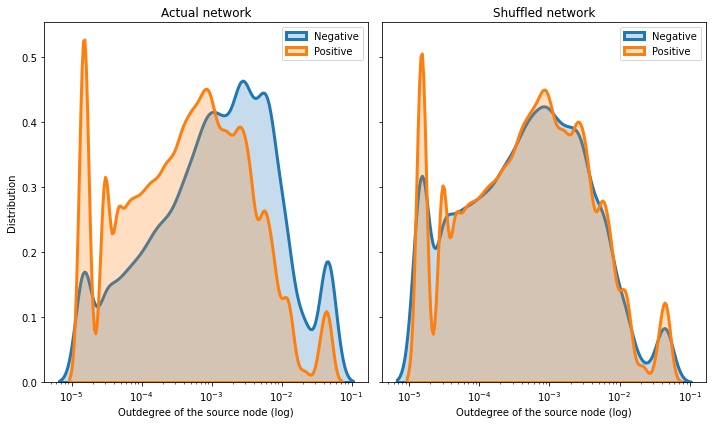

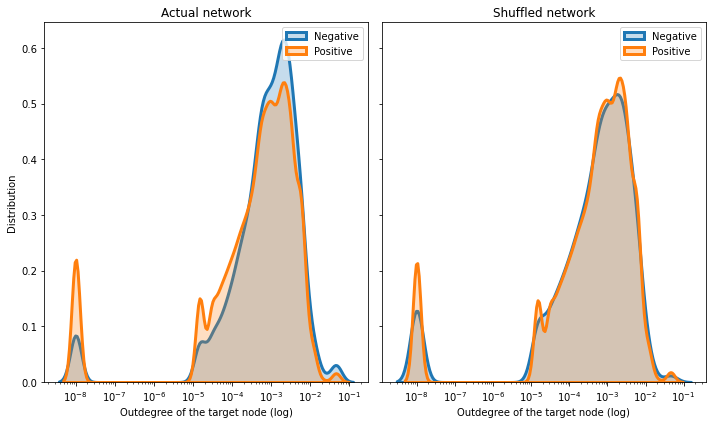

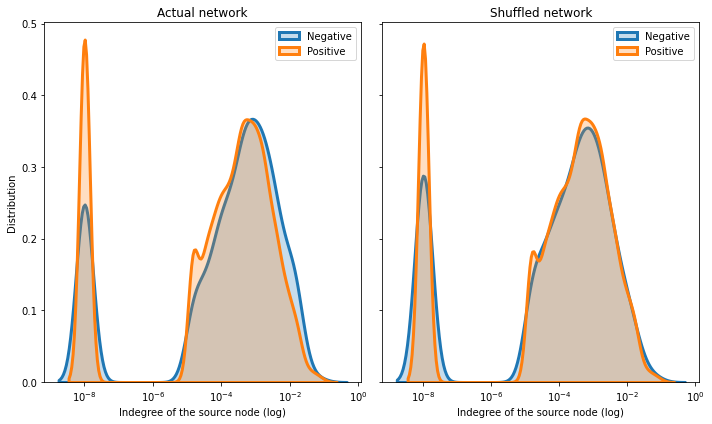

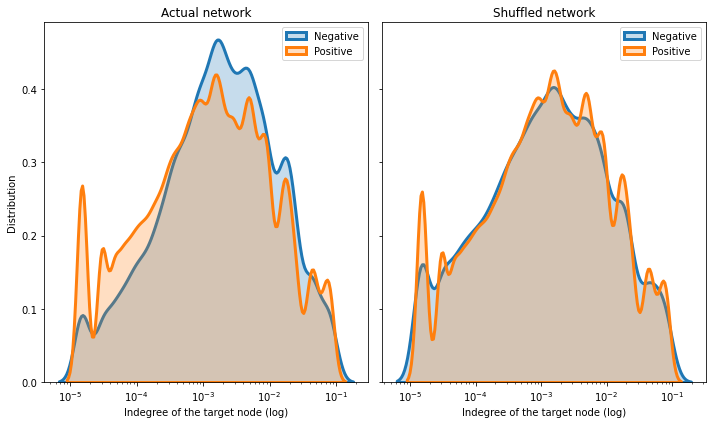

In [32]:
CompareCentrality(last_network, shuffled, "out", "source")
CompareCentrality(last_network, shuffled, "out", "target")
CompareCentrality(last_network, shuffled, "in", "source")
CompareCentrality(last_network, shuffled, "in", "target")

These density plots are of strong interest, as they provide information about the structure of the graph relative to the positive and negative edges. In particular, in the first one, we consider the distribution of the number of edges leaving the source node, and compare it when the edge considered is positive or negative. We observe that negative edges tend to have an outdegree that is higher than the positive one, compared to the shuffled version of the network. This implies that negative edges are more often created from a source subreddit that creates more hyperlink to other subreddits.

This phenomemon is also observed (but to a lesser extent) when we consider the indegree of the source, or the outdegree/indegree of the target subreddit.
Thus, the Reddit network seems to have negatives edges that tend to be more linked in the graph than the positive ones, which then create more triads, in particular of type *++-*, *+--* and *---*.

To account for this, we consider a randomised estimate of the number of triad. More precisely, we let each node to vote for one outgoing edge $e_n$ and we then sum over all the nodes the number of triads of each type passing by $e_n$. We then take the expectation of it. Mathematically, we have

$$T_w(k)=\mathbf{E}\left[\frac{1}{3}\sum_{n}|\text{Triad}_{k}(e_n)|\right]=\frac{1}{3}\sum_{e}|\text{Triad}_{k}(e)|\mathbf{\tilde{P}}(e)=\frac{1}{3}\sum_{e}\frac{|\text{Triad}_{k}(e)|}{\text{Outdegree}(\text{source}(e))}$$

where $k$ is the type of triad that we want to count (+++, ++-, +-- or ---), and $\text{Triad}_{k}(e)$ is the number of triads of type $k$ that contain the edge $e$. The 1/3 factor comes from the fact that a triad might contribute to $\text{Triad}_{k}(e)$ of three nodes.

This weighted is already implemented in the functions for status and balance count, with the parameter *normalisation*.

For the balance theory, here is what we obtain:

In [33]:
computeTable3(dataset, dataset_shuffled, normalisation = True)

,Weighted_Triad,Weighted_Triad_shuffled,diff
+++,51619.968769,49695.547949,1924.420820
+--,1304.998432,895.509495,409.488937
++-,9243.865443,11643.537332,-2399.671889
---,87.427310,21.665178,65.762132


Here, the only type of triad having a negative surprise is *++-*, while all others have a positive suprise. This implies that if we were to select randomly an hyperlink between to subreddits in our graph, then we would in expectation find more triads of type *+++*, *+--* and *---* than we should with a completely random network, and less triads of type *++-*. These results are quite in accordance with the *weak structural balance theory*, although the definition that are used are no longer the same, as here we take into account the indegree and outdegree of the nodes.

Again, this new definition for computing the number of triads (weighted) shows that the negative edges indeed tend to be more linked in the graph than the positive ones, which then results in an overrepresentation of triads with one or more negative edges.

The same analysis can be done with the status theory:

In [34]:
# using normalisation
counts, plusG, plusR, generative_baseline, receptive_baseline = status_count(dataset, True)
# convert result to a pandas dataframe
# plusG= nb of triad with positive AB/outdegree as defined above
# plusR= nb of triad with positive AB/indegree
table_status = pd.DataFrame([counts, plusG, plusR, generative_baseline, receptive_baseline], index=[
                            "count", "plus_countG", "plus_countR", "gb", "rb"]).T

surprise_status(table_status, True)
consistency(table_status)
table_status

,count,plus_countG,plus_countR,gb,rb,sg,sr,Sg,Sr,Bg,Br
t1,1049764.0,14812.098539,8187.505610,15135.007686,8480.182453,-2.643885,-3.191149,False,False,False,False
t2,81368.0,644.702008,462.125323,678.517607,466.294973,-1.303632,-0.193650,True,False,True,True
t3,1034788.0,15568.394371,15667.896135,15875.163801,15927.927686,-2.453636,-2.076418,True,False,False,False
t4,76650.0,646.285490,868.000335,672.437126,895.328560,-1.012946,-0.918695,False,False,True,True
t5,130096.0,805.940829,496.058353,769.690429,594.135690,1.310519,-4.032922,True,True,False,True
t6,13945.0,65.046535,63.189980,65.305929,71.415928,-0.032174,-0.975896,True,True,False,False
t7,108639.0,816.468574,908.100104,771.447690,1038.458464,1.626703,-4.064714,False,True,False,True
t8,12566.0,71.695462,110.591541,70.603287,125.739116,0.130348,-1.357662,True,True,True,False
t9,923299.0,13996.025147,7893.646198,14269.875554,8097.096582,-2.310392,-2.270945,False,True,False,False
t10,82486.0,742.099647,493.172067,777.221068,491.270486,-1.265772,0.086050,True,False,True,False


In [35]:
getConsistencyResults(table_status)

Consistency of balance with generative surprise: 7
Consistency of balance with receptive surprise: 7
Consistency of status with generative surprise: 9
Consistency of status with receptive surprise: 7


Surprisingly, the consistency results are not better than before. However, as we take into account the indegree and outdegree for weighting the sum, the results are not as easily interpretable as before. The status theory seems to work a bit better however in this case.

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***
### GLM models for balance and status
<a id = global_glm></a>

Here, we present an approach to test whether balance or status holds for the graph network or a combination of both. Using the dataset we built at the beginning, we are looking to predict the sign of an edge of a triad, depending on the sign of the others, as well as on the generative baseline of the subreddit creating the hyperlink (for which the sentiment of the hyperlink must be predicted).

In order to do this, we use a binomial model, with logit link function, that is, a mean $\mu$ is :
$$
\mu = \frac{\exp(X\mathbf{\beta})}{1 + \exp(X\beta)}, 
$$
is estimated for each triad, where $\mathbf{\beta}$ is the parametes vector that we are estimating, and $X$ is the feature matrix consisting of whether the triad has two other positive edges, one positive and one negative, or all negative edges, and also the generative baseline (to be more precise a function of the generative baseline, that we note $p = \log[\text{gen_baseline} / (1-\text{gen_baseline})]$).
Note that since we are using a binomial model with one trial, its expectation is equal to the probability of being equal to 1 (for the response variable). 

In [28]:
# fit a logistic model to the dataset (GLM offers more statistics than Logist)
def fit_glm(dataset,balance=True,alpha=0.05,display=True):
    def f_test_print(fit,hypotheses,txt=None):
        s=""
        if txt is not None:
            s+=txt+": "
        f_test = fit.f_test(hypotheses)
        if display:
            print(s+"p-value {:0.3f} for hypothesis {}".format(f_test.pvalue, hypotheses))
        return f_test.pvalue
    if balance:
        fit = sm.GLM(get_one_hot(dataset.y, 2)[:, (1, 0)], dataset[columns_balance+["p"]], family=sm.families.Binomial()).fit()
        if display:
            print(fit.summary())
        # deviation to the mean
        print(fit.params[columns_balance]-fit.params[columns_balance].mean())
        # significative?
        hypotheses = '(t3B = (t3B+t12B+t0B)/3)'
        f_test_print(fit,hypotheses)
        hypotheses = '(t12B = (t3B+t12B+t0B)/3)'
        f_test_print(fit,hypotheses)
        hypotheses = '(t0B = (t3B+t12B+t0B)/3)'
        f_test_print(fit,hypotheses)
    else:
        # fit the model with receptive and generative baseline
        fit = sm.GLM(get_one_hot(dataset.y, 2)[:, (1, 0)], dataset[columns_status+["p"]], family=sm.families.Binomial()).fit()
        fit1 = sm.GLM(get_one_hot(dataset.y, 2)[:, (1, 0)], dataset[columns_status+["r"]], family=sm.families.Binomial()).fit()
        if display:
            print("Generative")
            print(fit.summary())
            print("Receptive")
            print(fit1.summary())
        # deviation from the mean
        dev_mean=pd.concat((fit.params[columns_status].to_frame(name="sg")-fit.params[columns_status].mean(),
                         fit1.params[columns_status].to_frame(name="sr")-fit1.params[columns_status].mean()),axis=1)
        if display:
            print(dev_mean)
        # compare values to the mean
        columns_names = ""
        for col in columns_status:
            columns_names += str(col)+"+"
        columns_names = columns_names[:-1]
        pvalues_fit = []
        pvalues_fit1 = []
        for col in columns_status:
            hypotheses = '('+str(col)+' = ('+columns_names+')/16)'
            pvalues_fit.append(f_test_print(fit,hypotheses,"Generative"))
            pvalues_fit1.append(f_test_print(fit1,hypotheses,"Receptive"))
        if display:    
            print("="*100)
            print("="*100)
        table_status_regr = dev_mean.join(
            (pd.Series(pvalues_fit, index=columns_status) <= alpha).to_frame(name="pg"))
        table_status_regr = table_status_regr.join(
            (pd.Series(pvalues_fit1, index=columns_status) <= alpha).to_frame(name="pr"))

        consistency(table_status_regr)
        getConsistencyResults(table_status_regr)
        return table_status_regr

In [63]:
fit_glm(dataset,display=True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:              4077337
Model:                            GLM   Df Residuals:                  4077333
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4923e+06
Date:                Wed, 16 Dec 2020   Deviance:                   2.9846e+06
Time:                        22:09:59   Pearson chi2:                 3.68e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
t3B            0.0866      0.004     23.663      0.0

To summarize, *t3B* correspond to triads with only positive edges, *t0B* with only negative edges, and *t12B* to one negative and two positives. In this case, we have that if the other two edges are positive, then the other edge is most likely to be also positive. Also, if the generative baseline is high, the edge is more likely to be positive than negative. One must however check the confidence intervals and p-values, to see if the parameters are significative, which is the case.

One can do the same analysis with the status categories (the 16 type of triad):

In [43]:
# take 1 minute
table_status_glm=fit_glm(dataset,False)

Generative
                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:              4077337
Model:                            GLM   Df Residuals:                  4077320
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4921e+06
Date:                Wed, 16 Dec 2020   Deviance:                   2.9842e+06
Time:                        19:51:14   Pearson chi2:                 3.69e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
t1             0.0892      0.004     20.9

The balance theory, with this approach, seems to hold better than the status one. The graph is more often consistent with balance (however we can notice that the receptive surpise is slighlty better for the status theory), confirming that the link formation in Reddit network is closer to a *friendship* relation than a *respect* relation. Note also that some p-values are not significative, which means that some of those categories have no effect.

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***
## At a local scale: clustering analysis
<a id = local_clustering></a>


The aim of this part is to cluster the network, this is unfortunately not easy as the embeddings available to us are based on user behaviour so while the paper for example manually labels U.S. cities this would be impossible to do here in an unsupervised manner. Thus, the clusters that could be identified with the embeddings are 'communities' of users with similar interests and not necessarily categories as these communities might and actually do have interests in multiple 'categories'. 

### Grouping the subreddits into categories
<a id = local_build></a>


In [40]:
# if already computed, otherwise skip this cell
last_network = pd.read_pickle(pickle_dir+"last_network.pkl")
dataset = pd.read_pickle(pickle_dir+"triad_last_network.pkl")
shuffled = pd.read_pickle(pickle_dir+"shuffled.pkl")
dataset_shuffled = pd.read_pickle(pickle_dir+"triad_shuffled.pkl")

Here are the names of subreddit in the embedding dataset:

In [41]:
embedding_2= embedding_raw[embedding_raw.index.isin(uniqueNode)]   # for clustering, remove index column
embedding['index']

0                     spiders
1                   askreddit
2        globaloffensivetrade
3                   fireteams
4                       funny
                 ...         
31233                    tsbd
31234                mirwin11
31235     whatcanidoforbernie
31236                    33rd
31237             aberystwyth
Name: index, Length: 31238, dtype: object

Now here comes the part where we cluster the network

_**Warning:** the code was tested with python 3.7.3, with pynndescent 0.3.2. We encountered some errors when changing the version of this package, as well as the python version itself. If you do not want to change the version, execute the following cell, and do not execute the next cell (where we call the function **dim_reduction**)._

In [80]:
# load the labels, embeddings reduced and model
labels =  pickle.load( open( pickle_dir+"labels_f.data", "rb" ) )
embedding_reduced =  pickle.load( open( pickle_dir+"embedding_reduced.data", "rb" ) )
model =  pickle.load( open( pickle_dir+"model.final", "rb" ) )
print("Label shape: {}".format(labels.shape))

Label shape: (31238,)


In [8]:
# To be executed wiuth python 3.7.3 and pynndescent 0.3.2
perplexity = 250
exaggeration = None
n_iter = 500
early_exaggeration = 12
early_exaggeration_iter = 250
learning_rate = 'auto'
t_sne_params = (perplexity, exaggeration, n_iter, early_exaggeration, early_exaggeration_iter, learning_rate) 

# we use the openTSNE package because the sklearn version is much too slow
embedding_reduced = dim_reduction(embedding_2, "t-SNE", dim_out = 2, dim_in= 0, t_sne_params = t_sne_params, labels_ = None)

Dimension reduction with t-SNE
--------------------------------------------------------------------------------
TSNE(neighbors=None, perplexity=250, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 750 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 217.36 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 16.57 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.74 seconds
===> Running optimization with exaggeration=12.00, lr=2603.17 for 250 iterations...
Iteration   50, KL divergence 4.2526, 50 iterations in 36.1521 sec
Iteration  100, KL divergence 4.1338, 50 iterations in 31.8330 sec
Iteration  150, KL divergence 4.1308, 50 iterations in 42.3460 sec
Iteration  200, KL divergence 4.1302, 50 iterations in 34.1677 sec
Iteration  250, KL divergence 4.1300, 50 iterations in 33.0835 sec
   --> Time elapsed: 177.58 seconds
===> 

In [43]:
X = embedding_reduced
print("Shape of reduced embeddings: {}".format(X.shape))

Shape of reduced embeddings: (31238, 2)


#### Gaussian mixture model
Given the reduced embeddings, in two dimension, we now cluster them with the gaussian mixture model. We set the number of components to 16, with *full* covariance matrix.

In [44]:
# GMM
cv_type ="full"
model = mixture.BayesianGaussianMixture(n_components=16,
                                covariance_type=cv_type,
                                weight_concentration_prior=1e-6)
model.fit(X)
labels = model.predict(X)

Below is the resulting clustering. Some clusters are well visually identified and correctly clustered by the GMM.

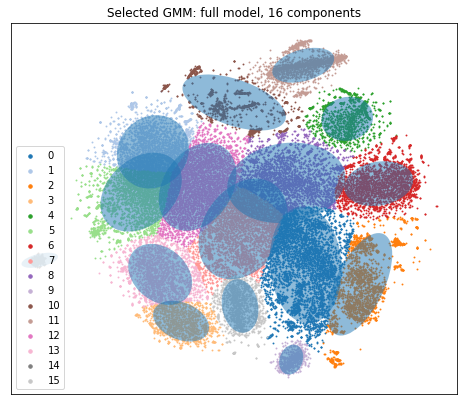

In [45]:
plot_GMM(gmm=model, X=X)

In [46]:
# import imp
# imp.reload(helper_functions)
# helper_functions.plot_simple(labels, labels, embedding_reduced)

After some trials the embedding and labels found above were found to be as good as we could hope for. 
As can be seen by skimming through the subreddits in each community(cluster) we have the following clearly identifiable coherant communities:
* **7** is probably subreddits popular with a pornographic community
* **11** is probably highly subreddits popular with some sort of political community and maybe others.
* **8** is probably subreddits popular with the gaming community.
* **1** is probably subreddits popular with a (super-)community of subcommunities of users living in Japan. For example japanese gammers and photography enthusiasts and so on.
* Other communities were identified as well but with less certainity.

The perplexity parameter and other parameters were choosen so as to maximise the number of identifiable clusters taken into account these condition(s):
* Coherent communities which were identified before should ideally be always re-identifiable. e.x. all perplexities > 5 have a clearly identifiable pornographic community so inline with this condition perplexity should be choosen to be more than 5
* Maximise the number of clearcut seperate **coherant** communities. e.x. the pornographic community is a perfect example as the community and categorly overlap almost perfectly, the pornographic community seem to be mainly interested in porn.

Saving the clusters (only when they were computed before).

In [47]:
# pickle.dump( labels,open( pickle_dir+"labels_f.data", "wb" ) )
# pickle.dump( np.array(embedding_reduced),open( pickle_dir+"embedding_reduced.data", "wb" ) )
# pickle.dump( np.array(model),open( pickle_dir+"model.final", "wb" ) )

In [48]:
subreddits= np.array(embedding_raw.index)
#jp; all subreddit with "_jp" or "_ja" in the handle are probably japanese 
japanese_subreddits=subreddits[list(map(lambda x: '_jp' in x or'_ja' in x , subreddits))]
print("A lot of overlap between categories and communities, for example for the japanese category with size >~ {}".format(len(japanese_subreddits)))

A lot of overlap between categories and communities, for example for the japanese category with size >~ 124


In [49]:
japanese_subreddits

array(['vablog_ja', 'vocaloid_utau_jp', 'military_jp', 'webcomic_ja',
       'nsfw_japan', 'lisp_ja', 'skyrimmod_jp', 'yuri_jp', 'soccer_jp',
       'prowrestling_ja', 'inbou_ja', 'sky_ja', 'nintendo_jp',
       'erogenews_ja', 'digitalgadget_jp', 'kancolle_ja', 'tv_ja',
       'kokusaijyousei_ja', 'anison_jp', 'team_japanese', 'software_ja',
       'programming_jp', 'cryptocurrency_ja', 'foodporn_ja', 'apple_jp',
       'radio_ja', 'motorsports_ja', 'whistory_ja', 'puzzleanddragons_ja',
       'science_jp', 'gamemusic_jp', 'xbox_jp', 'lovelive_ja',
       'security_ja', 'imas_ja', 'hackintosh_ja', 'sumo_ja',
       'motorcycle_ja', 'newsoku_jp', 'tvdrama_jp', 'scarystory_jp',
       'oekaki_ja', 'animefigures_ja', 'wakeupgirls_jp', 'politics_ja',
       'nsfw_hentai_n_jav', 'jigger_jack', 'occult_ja', 'op_jade_helm_15',
       'gamenews_ja', 'android_jp', 'pcgames_ja', 'eroson_jp', 'sicp_ja',
       'streetfighter_jp', 'stationery_jp', 'news_ja', 'pokemongo_ja',
       'pripara_ja', '

The Japanese community seem to mainly reside in cluster 1 but there are still some instances ont in that cluster, confiming the non-feasibility of a category approach.

In [50]:
# print(np.array([(subreddit, labels[np.where(subreddits==subreddit)][0]) for subreddit in japanese_subreddits]))

In [11]:
print(np.array(embedding['index'])[labels==1][:20])

['frozen' 'redditrequest' 'zootopia' 'freeebooks' 'csshelp' 'japannews'
 'efreebies' 'comicbookart' 'maddenbros' 'alternativeart'
 'imaginarymonsters' 'ads' 'korrasami' 'imaginarycharacters'
 'imaginarylandscapes' 'kreiswichs' 'sunsetshimmer' 'kindlefreebies'
 'modhelp' 'footballamerica']


<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

In the following parts, we perform a deeper analysis of the clusters, checking if the balance and status theories hold or not for each cluster. 


### Cluster analysis: building the dataset
<a id = local_build_dataset></a>

The following cell should have been executed before. Otherwise, uncomment it and execute it:

In [52]:
# # Create and register a new `tqdm` instance with `pandas`
# tqdm.pandas()

# # Groupby preserves the order of rows within each group.
# # combined is sorted by dates before -> this is still true in the groups
# last_network_id = combined.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"], sort=False).progress_apply(
#     lambda x: selectLastEdge(x)).explode().reset_index(drop=True)
# last_network = combined[combined.id.isin(last_network_id)]

In [53]:
#baseline_gen, baseline_rec, outdegree, indegree = baseline(last_network)
#dataset = buildDataset(last_network, baseline_gen, baseline_rec, outdegree, indegree)
#dataset["p"] = np.log(np.maximum(dataset["generative_baseline"],
#                                 1e-10)/np.maximum(1-dataset["generative_baseline"], 1e-10))
#dataset["r"] = np.log(np.maximum(dataset["receptive_baseline"],
#                                 1e-10)/np.maximum(1-dataset["receptive_baseline"], 1e-10))
#buildBalanceCategory(dataset)

100%|██████████| 339643/339643 [12:51<00:00, 440.48it/s] 


In [54]:
# #shuffled variants
# #Create a shuffled version of last_network
# shuffled = last_network.copy().reset_index(drop=True)
# #random sign (keeping the same fraction of positive edges)
#shuffled.LINK_SENTIMENT = shuffled.LINK_SENTIMENT.sample(
#    frac=1).reset_index(drop=True)

In [55]:
## dataset_shuffled
#baseline_gen, baseline_rec, outdegree, indegree = baseline(shuffled)

#dataset_shuffled = buildDataset(shuffled, baseline_gen, baseline_rec, outdegree, indegree)
#dataset_shuffled["p"] = np.log(np.maximum(dataset_shuffled["generative_baseline"],
#                                          1e-10)/np.maximum(1-dataset_shuffled["generative_baseline"], 1e-10))
#dataset_shuffled["r"] = np.log(np.maximum(dataset_shuffled["receptive_baseline"],
#                                          1e-10)/np.maximum(1-dataset_shuffled["receptive_baseline"], 1e-10))
#buildBalanceCategory(dataset_shuffled)

100%|██████████| 339643/339643 [12:46<00:00, 443.37it/s] 


For this part we will do the same analysis we did for the global network for each of the 16 communities (clusters) then we will focus on the clearly identifiable communities for a more detailled analysis.

In [56]:
dataset_shuffled.head()

,y,outdegree,indegree,generative_baseline,receptive_baseline,nodeA,nodeB,nodeC,timestamp,t1,...,t14,t15,t16,p,r,t3B,t2B,t1B,t12B,t0B
0,1.0,32.0,6.0,0.9375,0.833333,corejerk,bestof2013,posthardcore,2014-01-01 04:58:04,0.0,...,0.0,0.0,0.0,2.708050,1.609438,1.0,0.0,0.0,0.0,0.0
1,1.0,32.0,6.0,0.9375,0.833333,corejerk,bestof2013,posthardcore,2014-01-01 04:58:04,0.0,...,0.0,0.0,0.0,2.708050,1.609438,1.0,0.0,0.0,0.0,0.0
2,1.0,32.0,6.0,0.9375,0.833333,corejerk,bestof2013,metalcore,2014-01-01 04:58:04,0.0,...,0.0,0.0,0.0,2.708050,1.609438,1.0,0.0,0.0,0.0,0.0
3,1.0,32.0,6.0,0.9375,0.833333,corejerk,bestof2013,metalcore,2014-01-01 04:58:04,0.0,...,0.0,0.0,0.0,2.708050,1.609438,0.0,0.0,1.0,1.0,0.0
4,1.0,4.0,151.0,1.0000,0.933775,mlpccg,mylittlepony,mlptcg,2014-01-02 03:03:26,0.0,...,0.0,0.0,0.0,23.025851,2.646175,1.0,0.0,0.0,0.0,0.0


<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

### Cluster analysis: Intercluster interactions
<a id = local_inter_relations></a>

First, we assign to each node a label, following the classifications we did above. The label correspond to the id of the cluster the subreddit is grouped into.

In [72]:
# If not already done:
labels =  pickle.load( open( pickle_dir+"labels_f.data", "rb" ) )

# only select nodes that are classified
uniqueNode = combined.SOURCE_SUBREDDIT.append(combined.TARGET_SUBREDDIT).unique()
embedding = embedding_raw[embedding_raw.index.isin(uniqueNode)].reset_index()

# assign to each node a label
classification=embedding["index"].to_frame("name").join(pd.DataFrame(labels,columns=["label"]))
classification.head()

,name,label
0,spiders,4
1,askreddit,4
2,globaloffensivetrade,8
3,fireteams,2
4,funny,4


Then, we get some interesting statistics about each clusters. This will help us to remove clusters that will not suit our analysis (for example when the number of edges inside the cluster is too low).

In [73]:
#list_cluster_edges = [(percentage of edges coming of C but not ending in C, percentage of -ve edges coming of C but not ending in C )] 
list_cluster_edges = [] 

# for each cluster...
for cluster_index in range(16):
    # find node and edges in the cluster
    cluster_node=classification[classification.label==cluster_index].name
    cluster_edges=combined[combined.SOURCE_SUBREDDIT.isin(cluster_node)&combined.TARGET_SUBREDDIT.isin(cluster_node)]
    intercluster_edges= combined[combined.SOURCE_SUBREDDIT.isin(cluster_node) & np.logical_not (combined.TARGET_SUBREDDIT.isin(cluster_node))] # source in cluster, target in another cluster
    source_cluster =combined[combined.SOURCE_SUBREDDIT.isin(cluster_node)]
    target_cluster =combined[combined.TARGET_SUBREDDIT.isin(cluster_node)]
    
    num_edges_source_cluster = source_cluster.shape[0]
    percentage1 = cluster_edges.shape[0]/source_cluster.shape[0]*100 
    #percentage of edges coming of C but not ending in C out of all edges coming out of all edges

    percentage2 = len(intercluster_edges[intercluster_edges.LINK_SENTIMENT == -1].index)/len(intercluster_edges.index)*100 
    #percentage of -ve edges coming of C but not ending in C
    
    percentage3 = len(cluster_edges[cluster_edges.LINK_SENTIMENT == -1].index)/len(cluster_edges.index)*100 if len(cluster_edges.index) >0 else 100  
    #percentage of -ve edges coming of C and ending in C

    list_cluster_edges.append([num_edges_source_cluster, percentage1, percentage2, percentage3 ])
    
np_cluster_edges=np.array(list_cluster_edges)
intercluster_table =pd.DataFrame(list(zip(np.array(range(16)), np_cluster_edges[:,0],
                              np_cluster_edges[:,1],  np_cluster_edges[:,2],   np_cluster_edges[:,3])),
                              columns=['cluster', '#edges with C as source', '% of edges  with C\' target',
                              '%-ve edges C\' as target', '%-ve edges with C as target'])
intercluster_table.set_index('cluster', inplace=True)
intercluster_table

,#edges with C as source,% of edges with C' target,%-ve edges C' as target,%-ve edges with C as target
cluster,,,,
0,33164.0,5.159209,6.301466,3.623612
1,19807.0,8.163780,7.113799,1.422387
2,38831.0,17.419072,9.190133,5.292726
3,18718.0,2.943691,11.713547,3.448276
4,226557.0,60.449247,8.320964,9.645715
5,23502.0,2.901881,6.354075,3.519062
6,11618.0,3.167499,6.071111,1.630435
7,8092.0,40.274345,10.324850,3.559374
8,99186.0,64.666384,3.763625,4.571250


These clusters \[2, 4, 7, 8, 9, 11, 14, 15\] were identified as the most relevant ones for analysis as  they are sufficiently populated with nodes *and* said nodes are sufficiently interacting with each other. This was done as otherwise the number of triads in the cluster would be insufficient for robust statistical analysis.

Thus, we combine the following clusters into an *other* category:
* Others : {0, 1, 3, 5, 6, 10, 12, 13} => 16

The other clusters that we will analyse more closely are the following:

In [74]:
important_clusters = [2, 4, 7, 8, 9, 11, 14, 15, 16]   # clusters of interest

other_list = [0, 1, 3, 5, 6, 10, 12, 13]   # other clusters
other_dic = {cluster_index:16 for cluster_index in other_list}

labels_final = []
for label in labels:
    if label in other_list:
        labels_final.append(other_dic[label])
    else:
        labels_final.append(label)
        
# *re*assign to each node a label
classification=embedding["index"].to_frame("name").join(pd.DataFrame(labels_final,columns=["label"]))
classification.head()

,name,label
0,spiders,4
1,askreddit,4
2,globaloffensivetrade,8
3,fireteams,2
4,funny,4


The subreddits in the _important clusters_ were then skimmed over and were labelled as such:

In [75]:
index_name_full = {  2: "Adult content", 
              4:'Popular subjects', 
              7: "Porn", 
              8: "Gaming", 
              9 : "Media", 
              11: 'Politics', 
              14: "Sports", 
              15: "Tech and related community", 
              16: "Others",
              20: "All"  }
index_name = {  2: "Adult content", 
              4:'Popular subjects', 
              7: "Porn", 
              8: "Gaming", 
              9 : "Media", 
              11: 'Politics', 
              14: "Sports", 
              15: "Tech and related community", 
              16: "Others"}

In [76]:
number_nodes = classification.groupby('label').count()
number_nodes.columns = ["number of nodes"]
number_nodes.index = index_name.values()
number_nodes

,number of nodes
Adult content,1241
Popular subjects,2453
Porn,1640
Gaming,2240
Media,551
Politics,2254
Sports,827
Tech and related community,1369
Others,18663


Number of nodes in each cluster

Here is a plot to visualize the subreddits in the two dimensional space we found with dimension reduction, grouped into the clusters we identified.

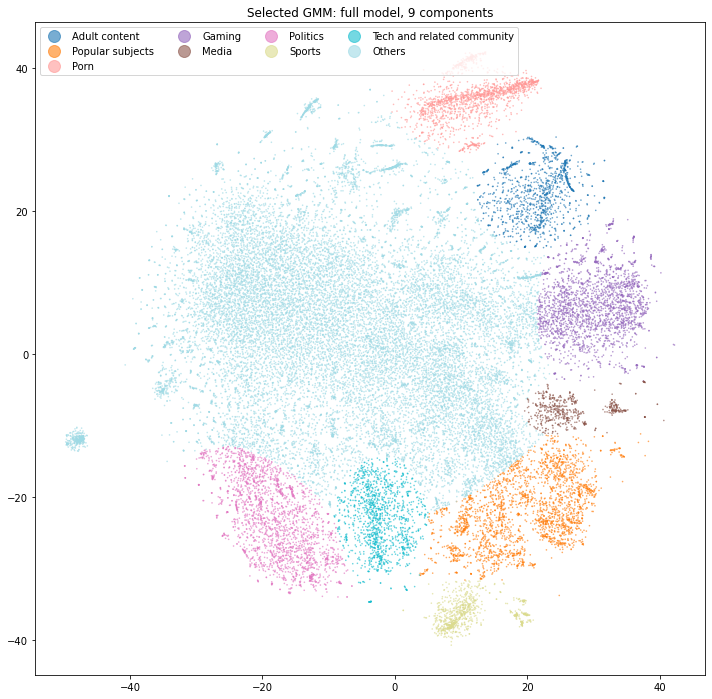

In [72]:
import imp
imp.reload(helper_functions)
helper_functions.plot_simple(list(index_name.values()), labels_final, embedding_reduced)

In [77]:
# Create a list of nodes in a cluster
list_cluster_nodes = []
for cluster_index in important_clusters:
    cluster_node = list(classification[classification.label==cluster_index].name)
    list_cluster_nodes.append(cluster_node)
    
# Create a dataset of traidic properties for each cluster
def filter_dataset(cluster, dataset = dataset):
    """
    Function that filters the triads in the triadic dataset by applying a condition on each of their three nodes
    returns:
    filtered_dataset: the filtered dataset
    """
    
    filtered_dataset = dataset[dataset['nodeA'].isin(cluster)].copy()
    filtered_dataset = filtered_dataset[filtered_dataset['nodeB'].isin(cluster)]
    filtered_dataset = filtered_dataset[filtered_dataset['nodeC'].isin(cluster)]

    return filtered_dataset
# gen_dataset = (filter_dataset(cluster, dataset ) for cluster in list_cluster_nodes)

In [78]:
list_combined = []
# Create a list of combined datasets for important clusters
for cluster in important_clusters:
    cluster_node=classification[classification.label==cluster].name

    # find edges with both endpoints in the cluster
    cluster_edges=combined[combined.SOURCE_SUBREDDIT.isin(cluster_node)&combined.TARGET_SUBREDDIT.isin(cluster_node)]
    list_combined.append(cluster_edges)

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

### Cluster analysis: cluster connectivity
<a id = local_connectivity></a>
For each cluster we kept, we compute here the proportion of positive and negative edges, as well as the connectivity score

In [79]:
# Creat graph for each
list_graph = [createGraph(combined) for combined in list_combined ]
  

# Calculate connectivity for each important cluster:
list_connectivity = [nx.transitivity(G) for G in list_graph] 
# Calculate positive negative edges number and proportion 
list_nb_positive_edges = [len(combined[combined.LINK_SENTIMENT == 1].index) for combined in list_combined ]
list_nb_negative_edges = [len(combined[combined.LINK_SENTIMENT == -1].index) for combined in list_combined ]
list_total_edges = [nb_positive_edges + nb_negative_edges for nb_positive_edges, nb_negative_edges in zip(list_nb_positive_edges, list_nb_negative_edges)]
list_proportion = [nb_negative_edges/max(total, 1e-10) for nb_negative_edges,total in zip(list_nb_negative_edges,list_total_edges)  ]

cluster_table =pd.DataFrame(list(zip(important_clusters, list_connectivity, number_nodes["number of nodes"], list_nb_negative_edges, list_nb_positive_edges, list_proportion)),
                            columns=['cluster', 'connectivity', "#nodes", '#-ve edges', '#+ve edges', 'proportion of -ve'])




# add global connectivity
G_global =createGraph(combined) 
global_conectivity = nx.transitivity(G_global)
nb_positive_edges_G = len(combined[combined.LINK_SENTIMENT == 1].index)
nb_negative_edges_G = len(combined[combined.LINK_SENTIMENT == -1].index)
total_G = nb_positive_edges_G + nb_negative_edges_G
proportion_G = nb_negative_edges_G/total_G
cluster_table = cluster_table.append({'cluster': 20, "connectivity": global_conectivity,  "#nodes":number_nodes["number of nodes"].sum(), '#-ve edges': nb_negative_edges_G, '#+ve edges': nb_positive_edges_G, 'proportion of -ve': proportion_G }, ignore_index=True)

# rewrite cluster names
cluster_table.set_index('cluster', inplace=True)
cluster_table.index = [index_name_full[index] for index in list(cluster_table.index)]

cluster_table

,connectivity,#nodes,#-ve edges,#+ve edges,proportion of -ve
Adult content,0.147330,1241.0,358.0,6406.0,0.052927
Popular subjects,0.089329,2453.0,13210.0,123742.0,0.096457
Porn,0.004380,1640.0,116.0,3143.0,0.035594
Gaming,0.116946,2240.0,2932.0,61208.0,0.045713
Media,0.206982,551.0,386.0,10089.0,0.036850
Politics,0.153128,2254.0,14283.0,69576.0,0.170322
Sports,0.645328,827.0,820.0,18876.0,0.041633
Tech and related community,0.128470,1369.0,210.0,7389.0,0.027635
Others,0.039145,18663.0,543.0,17891.0,0.029456
All,0.058851,31238.0,82210.0,776278.0,0.095761


The cluster with the highest connectivity score is the *Sports* one, well over the others clusters. The least connected one is the 7th cluster, corresponding to the *Porn community*. 
As for the proportion of negative edges, the *Politics* cluster has by far the highest proportion of negative edges, with more than 17%. The group with the highest proportion of positive edges is the *Tech and related*. 
In addition we can also observe:
* All clusters except the _Others_/ _Porn_ clusters have a higher connectivity than the global netwrok _All_, this is indicative of two things that the unsupervised clustering did in fact find well-connected communities indirectly. That the porn community for some reason is not very interactive or connected.
* Most clusters have a lower proportion of -ve edges than the global network except, notably, for the _Politics_ community, probably due to the inherent polemic nature.
* The _Porn_ community and _Others_ does *not* seem to be social communities but rather just a collection of subreddits viewed by people of similar interests or no discernable common one in the case of Others. This is why analysis on these communities would probably not be amenable to social theories such as balance or status as there is a relatively low amount of social interactions in these clusters as evidenced by the low proportion of the number of in-cluster edges to the number nodes in the cluster

Thus so far we can classify the clusters (communities) found in one of three ways based on their interactivity and negativity:

1. Interacting social communities (high connectivity and interactivity ~ #edges/#nodes and average negative edge proportion):

    i.  _Adult content_ : This community contains adult dating subreddits and similar subreddits

    ii. _Sports_

    iii._Tech_

    iv. _Gaming_

    v.  _Media_

2. *Polemic* interacting social communities (high connectivity and interactivity ~ #edges/#nodes and high negative edge proportion):

    i.  _Politics_

    ii. _Popular subjects_

3. Non-communities clusters (low connectivity or interactivity ~ #edges/#nodes):

    i.  _Porn_
    
    ii. _Others_

In this part we export the embeddings to create the interactive graph in the data-story

In [81]:
# Export an embedding-label df for interactive plotting
emb_red_label = pd.DataFrame(embedding_reduced, columns =['x','y'])
emb_red_label['community'] = [index_name[label] for label in labels_final]
emb_red_label['subreddits'] = [cluster_table.loc[community]['#nodes'] for community in emb_red_label['community']]
emb_red_label['links'] = [cluster_table.loc[community]['#-ve edges'] + cluster_table.loc[community]['#+ve edges'] for community in emb_red_label['community']]
emb_red_label.to_csv("emb_red_label.csv", index=False)

This next bit is to visualise these reuslts a bit better

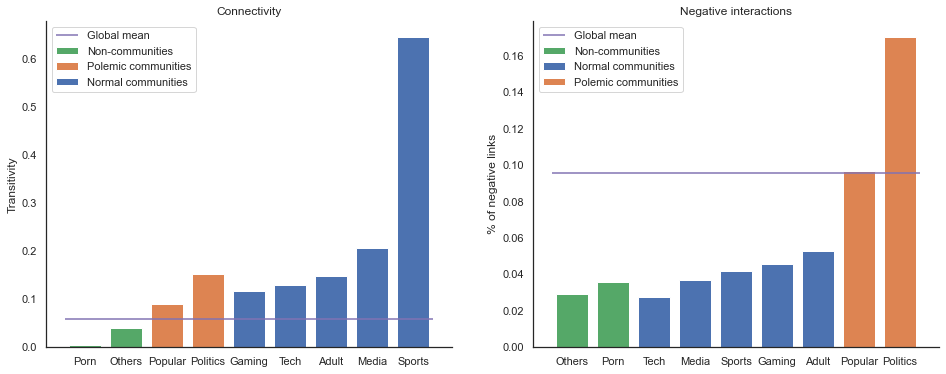

In [82]:
all = cluster_table.loc['All']

cluster_table_2 =cluster_table.drop('All').rename(index={'Tech and related community':"Tech", "Popular subjects":"Popular", "Adult content": "Adult"}).reset_index().sort_values(by=['connectivity']).rename(columns={'index':'Community'})
cluster_table_3 =cluster_table_2.sort_values(by=['proportion of -ve'])

Non_communities_idx =["Porn", "Others"]
Normal_communities_idx =["Gaming", "Media", "Tech", "Sports", 'Adult']
Polemic_communities_idx =["Politics", "Popular"]

sns.set(style='white')
fig, ax =  plt.subplots(1,2,figsize=(16,6))
ax[0].bar(cluster_table_2[cluster_table_2['Community'].isin(Non_communities_idx)]['Community'],cluster_table_2[cluster_table_2['Community'].isin(Non_communities_idx)]['connectivity'], color= sns.color_palette()[2])
ax[0].bar(cluster_table_2[cluster_table_2['Community'].isin(Polemic_communities_idx)]['Community'],cluster_table_2[cluster_table_2['Community'].isin(Polemic_communities_idx)]['connectivity'], color= sns.color_palette()[1])
ax[0].bar(cluster_table_2[cluster_table_2['Community'].isin(Normal_communities_idx)]['Community'],cluster_table_2[cluster_table_2['Community'].isin(Normal_communities_idx)]['connectivity'], color=sns.color_palette()[0])
ax[0].set_title("Connectivity")
ax[0].set_ylabel("Transitivity")

ax[0].hlines(y=all['connectivity'], label='Global mean', xmin=-0.5,xmax=8.5, color= sns.color_palette()[4])

# ax[0].set_xticklabels(cluster_table_2['Community'], rotation=45, fontsize=12)
ax[0].legend(["Global mean", 'Non-communities','Polemic communities', "Normal communities"])


ax[1].bar(cluster_table_3[cluster_table_3['Community'].isin(Non_communities_idx)]['Community'],cluster_table_3[cluster_table_3['Community'].isin(Non_communities_idx)]['proportion of -ve'], color= sns.color_palette()[2])
ax[1].bar(cluster_table_3[cluster_table_3['Community'].isin(Normal_communities_idx)]['Community'],cluster_table_3[cluster_table_3['Community'].isin(Normal_communities_idx)]['proportion of -ve'], color= sns.color_palette()[0])
ax[1].bar(cluster_table_3[cluster_table_3['Community'].isin(Polemic_communities_idx)]['Community'],cluster_table_3[cluster_table_3['Community'].isin(Polemic_communities_idx)]['proportion of -ve'], color= sns.color_palette()[1])
ax[1].set_title("Negative interactions")
ax[1].set_ylabel("% of negative links")

ax[1].hlines(y=all['proportion of -ve'], label='Global mean', xmin=-0.5,xmax=8.5, color= sns.color_palette()[4])
sns.despine()
# ax[1].set_xticklabels(cluster_table_3['Community'], rotation=45, fontsize=12)
ax[1].legend(["Global mean", 'Non-communities','Normal communities', "Polemic communities"])

#fig.savefig('Cluster_graph.svg',format='svg',dpi=300)

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

### Cluster analysis: Balance theory
<a id = local_balance></a>
As we saw in the global analysis, the balance theory does not seem to work hold, as stated in the original paper. We can nevertheless perform the same analysis here with the clusters, and detect if some clusters respect the theory and others not.

In [29]:
from IPython.display import display_html
def display_side_by_side(l):
    """ Function to display tables side by side in jupyter notebook """
    html_str=''
    for df, cluster_name in l:
        html_str+= df.style.set_caption(cluster_name).render()

    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

Now for each category, we count the number of undirected triads, as in the global analysis:

In [31]:
list_tables= []
for i, cluster_index in enumerate(important_clusters):
    print(cluster_index, index_name[cluster_index])
    if cluster_index <17:
        cluster = list_cluster_nodes[i]
        cluster_dataset = filter_dataset(cluster, dataset ) 
        cluster_dataset_shuffled =filter_dataset(cluster, dataset_shuffled ) 
        table = computeTable3(cluster_dataset, cluster_dataset_shuffled)
        del cluster_dataset
        del cluster_dataset_shuffled
        list_tables.append(table)

2 Adult content
Total Number of triad : 2358
4 Popular subjects
Total Number of triad : 563790
7 Porn
Total Number of triad : 702
8 Gaming
Total Number of triad : 104951
9 Media
Total Number of triad : 7625
11 Politics
Total Number of triad : 260224
14 Sports
Total Number of triad : 70684
15 Tech and related community
Total Number of triad : 7102
16 Others
Total Number of triad : 3042


One notes here major differences in the number of triads, which is also linked to the size of the clusters, that vary significantly. Here are the results for the balance theory:

In [32]:
list_tables_names = zip(list_tables, list(index_name.values()))
display_side_by_side(list_tables_names)

,Triad,p(T),p_0(T),s(T)
+++,2073.000000,0.879135,0.839271,5.270566
+--,41.000000,0.017388,0.007209,5.841952
++-,242.000000,0.102629,0.152672,-6.756238
---,2.000000,0.000848,0.000848,0.000000
,Triad,p(T),p_0(T),s(T)
+++,429134.000000,0.761159,0.793185,-59.372442
+--,15163.000000,0.026895,0.015399,70.097426
++-,118777.000000,0.210676,0.191025,37.534376
---,716.000000,0.001270,0.000390,33.446840
,Triad,p(T),p_0(T),s(T)


The differences for the surprise results are huge between the groups. The category *Adult content* seems to be the only category that respects the _weak_ balance theory, with a negative surprise only for triads of type _++-_. As for the others, the results are harder to interpret. The *Tech*, *Sports*, *Media*, *Gaming*, *Porn* all see a positive surprise only for triads of type _+++_.
 
Both polemic communities, *Popular subjects* and *Politics* communities, have a negative surprise for triads of type _+++_, and positive ones for all others, most surprisingly, triads of type _++-_ are overrepresented in these networks, which implies that the saying *the friend of my friend is my enemy* is disproportionately favored in these communities. This distortion is probably due to the fact that there is a disproportionate amount of negative interactions with disproportionate importance/ centrality similar to what was discussed in the global section.



<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

### Cluster analysis: Status theory
<a id = local_status></a>

Similarly, here are the results for the status theory:

In [33]:
list_tables2= []
for i, cluster_index in enumerate(important_clusters):
    print(cluster_index, index_name[cluster_index])
    if cluster_index <16:
        cluster = list_cluster_nodes[i]
        cluster_dataset = filter_dataset(cluster, dataset) 
        # not normalised
        counts, plusG, plusR, generative_baseline, receptive_baseline = status_count(cluster_dataset, False)
        # convert result to a pandas dataframe
        table_status = pd.DataFrame([counts, plusG, plusR, generative_baseline, receptive_baseline], index=[
                                    "count", "plus_countG", "plus_countR", "gb", "rb"]).T

        surprise_status(table_status, True)
        list_tables2.append(table_status)

2 Adult content
4 Popular subjects
7 Porn
8 Gaming
9 Media
11 Politics
14 Sports
15 Tech and related community
16 Others


And here are the results:

In [87]:
list_tables_names2 = zip(list_tables2, list(index_name.values()))
display_side_by_side(list_tables_names2)

,count,plus_countG,plus_countR,gb,rb,sg,sr
t1,588.000000,558.000000,558.000000,556.727670,554.379687,0.233823,0.643029
t2,27.000000,23.000000,23.000000,24.321028,21.870471,-0.850392,0.554130
t3,590.000000,559.000000,559.000000,555.753236,550.728037,0.571644,1.366233
t4,19.000000,17.000000,17.000000,17.310614,16.485008,-0.250367,0.348630
t5,19.000000,17.000000,17.000000,15.786247,17.442935,0.742782,-0.370471
t6,4.000000,3.000000,3.000000,3.309740,3.000605,-0.409848,-0.000699
t7,19.000000,16.000000,16.000000,15.710223,16.531996,0.175698,-0.363036
t8,15.000000,14.000000,14.000000,12.477127,13.593974,1.051246,0.359691
t9,556.000000,530.000000,530.000000,525.212565,523.956076,0.887740,1.099857
t10,32.000000,25.000000,25.000000,28.842890,25.509996,-2.278079,-0.224215


In [39]:
for table_status, cluster_name in zip(list_tables2, list(index_name.values())):
    print(cluster_name)
    surprise_status(table_status, True)
    consistency(table_status)
    getConsistencyResults(table_status)

Adult content
Consistency of balance with generative surprise: 10
Consistency of balance with receptive surprise: 12
Consistency of status with generative surprise: 11
Consistency of status with receptive surprise: 10
Popular subjects
Consistency of balance with generative surprise: 8
Consistency of balance with receptive surprise: 8
Consistency of status with generative surprise: 8
Consistency of status with receptive surprise: 8
Porn
Consistency of balance with generative surprise: 2
Consistency of balance with receptive surprise: 5
Consistency of status with generative surprise: 4
Consistency of status with receptive surprise: 5
Gaming
Consistency of balance with generative surprise: 8
Consistency of balance with receptive surprise: 7
Consistency of status with generative surprise: 8
Consistency of status with receptive surprise: 7
Media
Consistency of balance with generative surprise: 7
Consistency of balance with receptive surprise: 9
Consistency of status with generative surprise

Here we use the same consistency analysis done on the global scale. We can observe clearly that the previously defined non-polemic interacting social communities like _Adult content_ and _Sports_ and  _Tech_ respect the theory of balance more than the other communities. Most of the other communities respect Balance to the same extent as the global network with the notable exception of the _Porn_ community which as we discussed earlier doesn't seem to be much of an interactive social community but probably just a group of reddits viewed by individuals of similar interests who do not particularly interact. 

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

## An evolution through time: temporal analysis
<a id = temporal></a>

In this section, we will explore on dimension of the graph analysis linked to the temporality of the edge creations. 

In [54]:
# # If not already done:
# labels =  pickle.load( open( pickle_dir+"labels_f.data", "rb" ) )

# # only select nodes that are classified
# uniqueNode = combined.SOURCE_SUBREDDIT.append(combined.TARGET_SUBREDDIT).unique()
# embedding = embedding_raw[embedding_raw.index.isin(uniqueNode)].reset_index()

# # assign to each node a label
# classification=embedding["index"].to_frame("name").join(pd.DataFrame(labels,columns=["label"]))

First, we check if there is a trend in the proportion of new negative edges created, for each month. For each cluster, we get the proportion of positive edges created for each month, along with a time normalization parameter (renormalize timestamp to 0 mean and variance 1).

In [83]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf

# fit a linear model to detect if the proportion of newly create negative edges increase
all_data=pd.DataFrame()
cluster_to_check=[2,4,7,8,9,11,14,15]
index_name = {  2: "Adult content", 
              4:'Popular subjects', 
              7: "Porn", 
              8: "Gaming", 
              9 : "Media", 
              11: 'Politics', 
              14: "Sports", 
              15: "Tech and related community", 
              16: "Others"  }

# find node that are in this cluster
for cluster in cluster_to_check:
    cluster_node=classification[classification.label==cluster].name
    # find edges with both endpoints in the cluster
    cluster_edges=combined[combined.SOURCE_SUBREDDIT.isin(cluster_node)&combined.TARGET_SUBREDDIT.isin(cluster_node)]
    # group by month (sufficient large to have enough data) 
    monthly_proportion = cluster_edges.groupby([pd.Grouper(key='TIMESTAMP', freq='M')]).LINK_SENTIMENT.apply(lambda x: x[x > 0].sum()/len(x)).reset_index()
    monthly_proportion["time_norm"]=monthly_proportion.TIMESTAMP.astype(int)
    monthly_proportion["time_norm"]=(monthly_proportion.time_norm-monthly_proportion.time_norm.mean())/monthly_proportion.time_norm.std()
    monthly_proportion["cluster"]=cluster
    # then concat the dataframe
    all_data=pd.concat((all_data,monthly_proportion))
all_data=all_data.rename(columns={"LINK_SENTIMENT":"proportion"})
print(all_data)

    TIMESTAMP  proportion  time_norm  cluster
0  2014-01-31    0.971831  -1.663130        2
1  2014-02-28    0.983871  -1.584481        2
2  2014-03-31    0.951613  -1.497407        2
3  2014-04-30    0.980000  -1.413141        2
4  2014-05-31    0.941176  -1.326066        2
..        ...         ...        ...      ...
35 2016-12-31    0.930481   1.328313       15
36 2017-01-31    0.961538   1.415388       15
37 2017-02-28    0.985149   1.494036       15
38 2017-03-31    0.996094   1.581111       15
39 2017-04-30    0.954918   1.665377       15

[324 rows x 4 columns]


<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

### Checking the trend
<a id = temporal_trend></a>

Then, we fit an ordinary least square regression for each cluster, and check the results. As we can see below, the adjusted R-squared is quite high. One can now check the parameters estimates, to see if there is a major trend for one or another cluster.

In [84]:
sns.set()
ols_prop=smf.ols("proportion~C(cluster)+time_norm:C(cluster)-1",data=all_data).fit()
print(ols_prop.summary())
# R^2 is really high

                            OLS Regression Results                            
Dep. Variable:             proportion   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     147.3
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          1.40e-130
Time:                        10:16:27   Log-Likelihood:                 863.78
No. Observations:                 324   AIC:                            -1696.
Df Residuals:                     308   BIC:                            -1635.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(cluster)[2]           

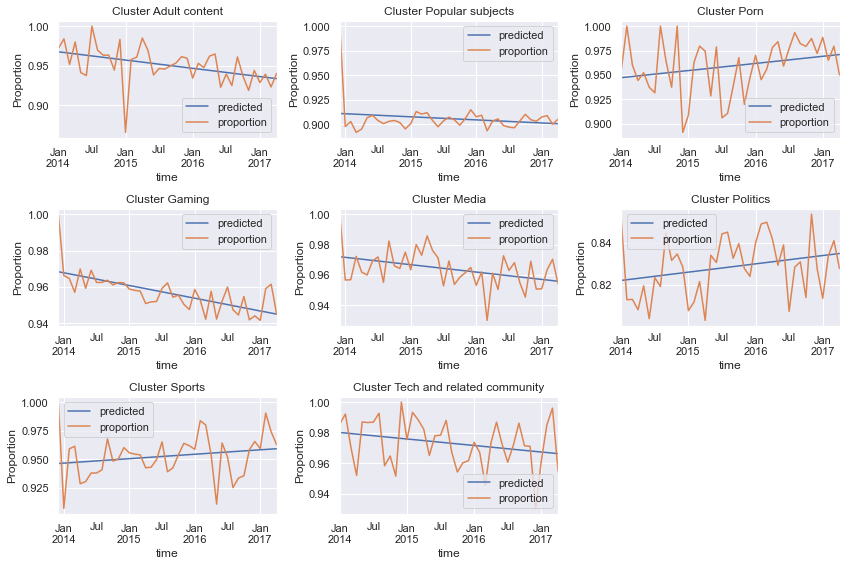

In [85]:
all_data["predicted"]=ols_prop.predict()
def plot_proportions(ax,i):
    all_data[all_data.cluster==i].set_index("TIMESTAMP")[["predicted","proportion"]].plot(ax=ax)
    ax.set_xlabel("time")
    ax.set_ylabel("Proportion")
    ax.set_title("Cluster {}".format(index_name[i]))

fig,axes=plt.subplots(3,3,figsize=(12, 8))

# unpack all the axes subplots
axs = axes.ravel()
for i,ax in enumerate(axs):
    if i<len(cluster_to_check):
        plot_proportions(ax,cluster_to_check[i])
fig.tight_layout(pad=1.0)
fig.delaxes(axes[2][2])

Clusters 2, 7 and 8 (maybe 9, but limit) have a significant parameter for time dependence, that is, the proportion of positive edges has a trend.
In particular, the cluster *Adult content* and *Gaming* have a negative trend, which implies that the proportion of negative edges in growing in time. This might question the results of the balance theory part for the future, as we might have (again, in the future), an underrepresentation of all positive triads. We saw that the *Gaming* community does not really follow the balance theory, but *Adult content* does.
The *Porn* community has a strong proportion of positive edges increase, although the results seem visually questionable (there seem to be also a cyclical trend).
The *Politics* community have a null trend (or at least, we can not reject this hypothesis), with the lowest proportion of positive edges among these categories.

In [86]:
all_data.cluster=all_data.cluster.apply(lambda i: index_name[i])
all_data

,TIMESTAMP,proportion,time_norm,cluster,predicted
0,2014-01-31,0.971831,-1.663130,Adult content,0.967496
1,2014-02-28,0.983871,-1.584481,Adult content,0.966695
2,2014-03-31,0.951613,-1.497407,Adult content,0.965808
3,2014-04-30,0.980000,-1.413141,Adult content,0.964949
4,2014-05-31,0.941176,-1.326066,Adult content,0.964062
...,...,...,...,...,...
35,2016-12-31,0.930481,1.328313,Tech and related community,0.967722
36,2017-01-31,0.961538,1.415388,Tech and related community,0.967360
37,2017-02-28,0.985149,1.494036,Tech and related community,0.967034
38,2017-03-31,0.996094,1.581111,Tech and related community,0.966672


<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

### Aside: bokeh
<a id = temporal_bokeh></a>
In the following, we make a bokeh plot for the data story page. The next two cells can be skipped, if the package bokeh is not installed.

In [59]:
# from https://yivan.xyz/bokeh
from jinja2 import Template

from bokeh.embed import components
from bokeh.resources import CDN

template = Template('''
<html lang="en">
<head>
<meta charset="utf-8">
{{ resources }}
{{ script }}
<style>
.embed-wrapper {
display: flex;
justify-content: center;
}
</style>
</head>
<body>
<div class="embed-wrapper">
{{ div }}
</div>
</body>
</html>
''')

def save_embed(fig, filename):
    script, div = components(fig)

    html = template.render(resources=CDN.render(),
                           script=script,
                           div=div)

    with open(filename, mode='w', encoding='utf-8') as f:
        f.write(html)

In [60]:
# bokeh plot
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource,HoverTool,Column
from bokeh.palettes import Category10
from bokeh.models.callbacks import CustomJS
from bokeh.layouts import Row
from bokeh.models.widgets import CheckboxGroup


tranformed=all_data[["TIMESTAMP","proportion","cluster"]].pivot(index="TIMESTAMP",columns="cluster",values="proportion")
predicted=all_data[["TIMESTAMP","predicted","cluster"]].pivot(index="TIMESTAMP",columns="cluster",values="predicted")

source = tranformed.reset_index()[1:].to_dict("list")# remove first row (contains nan)
source_predicted=predicted.reset_index()[1:].to_dict("list")
p = figure(plot_width=850, plot_height=400,x_axis_type='datetime')

# palette
colors=Category10[len(cluster_to_check)]
lines={}
line_true_data=[]
# add a line renderer
for cluster,color,i in zip(cluster_to_check,colors,range(len(cluster_to_check))):
    name=index_name[cluster]
    line_1=p.line(x='TIMESTAMP', y=name, line_width=2, source=source,
            legend_label=name,name=name, color=color,hover_line_alpha=1.0,alpha=0.5)
    line_2=p.line(x='TIMESTAMP', y=name, line_width=1, source=source_predicted, color=color,alpha=1,line_dash='dashed')
    lines["l"+str(i)]=line_1
    lines["l"+str(i)+"p"]=line_2
    if i!=3:
        line_1.visible=False
        line_2.visible=False

    line_true_data.append(line_1)

p.xaxis.axis_label = "Time"
p.yaxis.axis_label = 'Proportion of monthly new positive links'

hover_tool=HoverTool(line_policy='next',tooltips=[('date', '@TIMESTAMP{%F}'),('value', '$y'),('category','$name')],
          formatters={'@TIMESTAMP': 'datetime'},renderers=line_true_data)
    # Add the HoverTool to the figure
p.add_tools(hover_tool)
code=""
for i in range(8):
    code+="l"+str(i)+".visible =  checkbox.active.includes("+str(i)+");"
    code+="l"+str(i)+"p.visible =  checkbox.active.includes("+str(i)+");"

checkbox_button_group =  CheckboxGroup(labels=list(index_name.values())[:-1], active=[3])
lines["checkbox"]=checkbox_button_group
callback=CustomJS(args=lines,code=code)
checkbox_button_group.js_on_change('active', callback)

p.add_layout(p.legend[0], 'below')
p.legend.orientation = "horizontal"

layout=Row(p,Column(checkbox_button_group))
show(layout)
save_embed(layout, "evolution.html")

Here are a few diagnostic plots, checking of the normalized residuals are normally distributed and homogeneous. It is indeed the case, as we can see from the plot below, even though there are some outliers (see Cook distance)

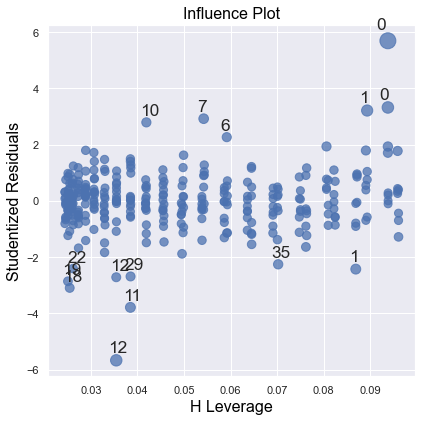

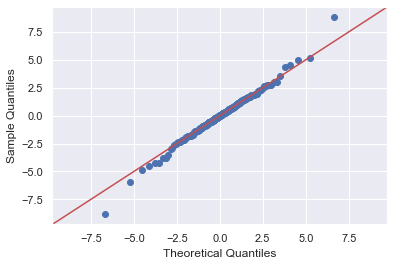

In [87]:
import scipy.stats as stats
from statsmodels.stats.outliers_influence import OLSInfluence

def plot_diagnostics(model,n):
    #fig = sm.graphics.plot_regress_exog(ols_prop, "x1")
    #fig.set_size_inches(10,8)
    #fig.tight_layout(pad=1.0)
    fig=sm.graphics.influence_plot(model,criterion="Cooks",size=16)
    fig.set_size_inches(6,6)
    fig.tight_layout(pad=1.0)
    
    res=OLSInfluence(model).resid_studentized_external
    p=len(model.params)
    # externally studentize residuals follow a student distribution with n-p-1 degree of freedom
    sm.qqplot(res,stats.t, distargs=(n-p-1,), fit=True, line="45")
    
plot_diagnostics(ols_prop,all_data.shape[0])

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***

### Finding conflicts
<a id = temporal_conflicts></a>


In the following and last part, our goal is to detect periods of *conflict* in the clusters of the graph. As this definition might seem to be very vague, we propose to analyse the number of negative edges created in some time interval (for example every month, week, or 2 week, etc), and check if there was a major increase. As the data are very noisy, we smooth the data with a gaussian kernel, so that taking the difference will not be affected to high frequencies in the data.
To detect these high increases, we fix a threshold to detect only major increases.

Once these peaks are detected, we take a time window arround the given date. Note that some clusters might have several dates with high increase!

Here is the function that we will use to detect these major increases:

In [92]:
from scipy.signal import find_peaks
from dateutil.relativedelta import *

def find_conflicts(df,th,freq,win_size,std=1):
    # group by frequency and compute the number of negative edges, for the frequency (ex: Month, 2 weeks, ...)
    seq=df.groupby([pd.Grouper(key='TIMESTAMP', freq=freq)]).LINK_SENTIMENT.apply(lambda x : x[x < 0].sum()) 
    # moving avg using a gaussian kernel-> less sensitive to high frequency when taking the difference operator
    seq=seq.rolling(win_size,win_type="gaussian").sum(std=std)
    # take the difference operator
    diff=seq-seq.shift()   # if diff < 0, then increase in the number of negative edges created
    
    # Plot:
    plt.plot(diff,label="Difference")
    plt.xlabel("Observation")
    plt.ylabel("Difference")
    xmin,xmax=plt.xlim()
    plt.hlines(th,xmin,xmax,colors="r",linestyles="dashed",label="threshold")
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.show()
    
    # find peaks over the theshold. Correspond to highly active phase
    which = diff[find_peaks(-diff,height=-th)[0]]
    duration=[int(word) for word in freq.split() if word.isdigit()]
    
    # define a window around the date
    windows=[]
    for date in which.index:
        delta=0
        if "M" in freq:
            if len(duration)>0:
                delta=relativedelta(months=duration[0])
            else:
                delta=relativedelta(months=+1)
        if "W" in freq:
            if len(duration)>0:
                delta=relativedelta(weeks=duration[0])
            else:
                delta=relativedelta(weeks=+1)
        if "D" in freq:
            if len(duration)>0:
                delta=relativedelta(days=duration[0])
            else:
                delta=relativedelta(days=+1)
        start=date-delta
        end=date+delta
        # find observation within this window
        windows.append(df.query("@start<TIMESTAMP<@end").set_index("SOURCE_SUBREDDIT"))
    return windows

And here we apply it for each cluster, for which we define (by set and trial) the following parameters:

4


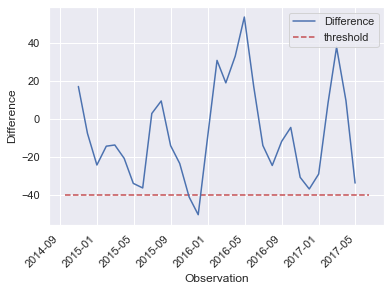

Percentage conflict: 15.94%


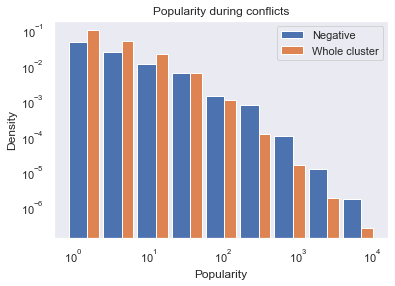

8


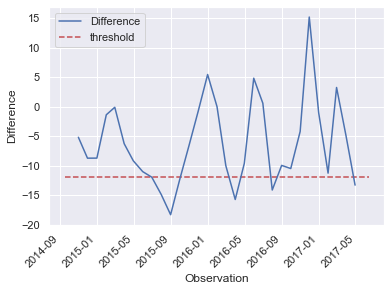

Percentage conflict: 5.89%


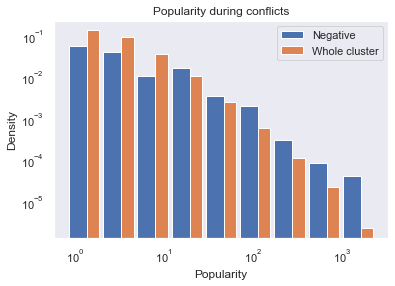

Percentage conflict: 6.61%


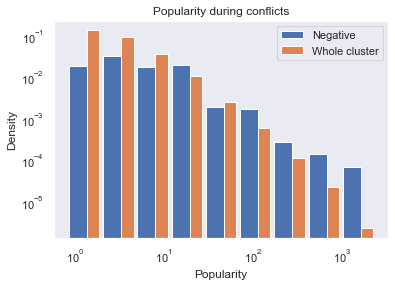

Percentage conflict: 6.52%


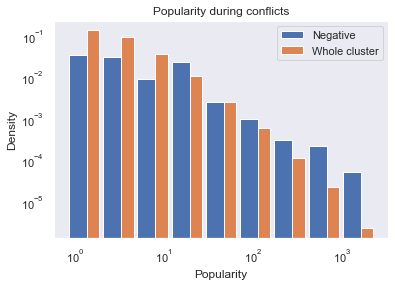

11


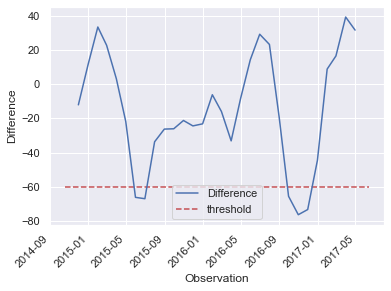

Percentage conflict: 15.71%


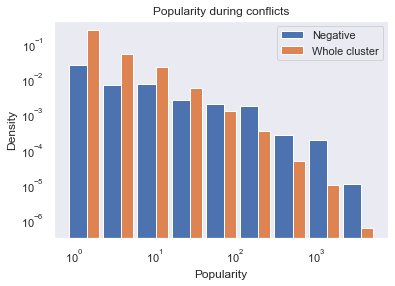

Percentage conflict: 19.88%


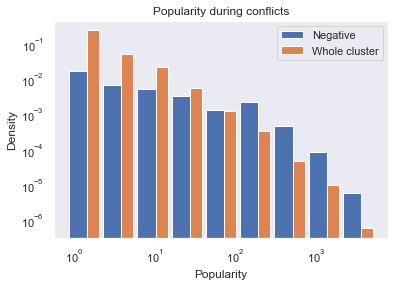

In [93]:
# we display the plot only for 4 ,8 ,11 (uncomment if you want more)
params=[#[-5, "2W", 10],#2
        [-40, "M", 10],#4
        #[-2, "M", 5],#7
        [-12, "M", 10],#8
        #[-3, "M", 10],#9
        [ -60, "M", 10]#11
        #[-10, "2W" ,10],#14
        #[-2, "2W", 10, 2]#15
        ]
cluster_to_check_conflict=[4,8,11]
for i,cluster in enumerate(cluster_to_check_conflict):
    print(cluster)
    # find cluster node
    cluster_node=classification[classification.label==cluster].name
    # find the cluster edges
    cluster_edges=combined[combined.SOURCE_SUBREDDIT.isin(cluster_node)&combined.TARGET_SUBREDDIT.isin(cluster_node)]
    # find the popularity (ie number of incoming edges) of the nodes in the cluster
    popularity=cluster_edges.groupby(by="TARGET_SUBREDDIT").apply(len)
    conflicts=find_conflicts(cluster_edges,*params[i])
    
    # For each conflict (there can be several for one cluster)
    for conflict in conflicts:
        
        # get the popularity of negative edges
        popularity_edge_neg=conflict[conflict.LINK_SENTIMENT==-1].join(popularity.to_frame("pop")).fillna(0)["pop"]
        #print(popularity_edge_neg)
        print("Percentage conflict: {:.2f}%".format(conflict[conflict.LINK_SENTIMENT==-1].groupby("SOURCE_SUBREDDIT").head().shape[0]/cluster_node.shape[0]*100))
        
        # then plot the density of the popularity of negative edges, and compare it with the popularity for the whole cluster
        plt.hist([popularity_edge_neg,popularity],label=["Negative","Whole cluster"],
                 bins=np.logspace(-0.1,np.log10(max(popularity)),10),
                 rwidth=0.9,
                 density=True)
        plt.grid()
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Popularity")
        plt.ylabel("Density")
        plt.title("Popularity during conflicts")
        plt.legend()

        plt.show()

Here are a summary of the results:
* cluster = 2 (param: -5 2W 10) -> underrepresentation of large (few observations)
* cluster = 4 (param: -40 M 10) -> overrepresentation of large
* cluster = 7 (param: -2 M 5) ->nothing (too few observations)
* cluster = 8 (param: -12 M 10) -> overrepresentation of large
* cluster = 9 (param: -3 M 10) -> underrepresentation of large (not clear)
* cluster = 11 (param: -60 M 10) -> underrepresentation of small 
* cluster = 14 (param: -10 2W 10) -> overrepresentation middle (not clear)
* cluster = 15 (param: -2 2W 10 2) -> not clear

These are very different from one cluster to another. Some, for example *Popular subjects* and *Gaming* have conflicting situations where subreddits that create a negative hyperlink others are quite popular (ie. they receive lots of connections from other subreddits). Some others, like *Media* and *Adult content* show opposite results, where attacking subreddits have small popularity. The others are quite uncertain, as the number of observation can be quite low.

<font size="1"> $\uparrow \uparrow $ [Table of contents](#table_of_contents) $\uparrow \uparrow $ </font> 
***
## Conclusion
<a id = conclusion></a>

The goal of this project was to reveal what is the underlying structure of the network:
* How hyperlinks are created between subreddits ?
* Can we characterise them using an existing social theory ?
* Are the results the same at all scale (i.e. when a single specific community is considered) ?
* Does the network exhibit structural changes through time ?

The analysis at a global scale did not reveal a particular trend in the proportion of negative hyperlinks created each month. Also, the balance and status theories proposed in the **Signed Networks in Social Media** paper do not seem to apply here, as the negative hyperlinks tend to be more involved in the creation of triads. To account for this, we proposed a counting method that takes into account the popularity of the subreddit creating the hyperlink, that is, the number of incoming links. Another approach was to consider a linear classifier, which confirmed the application of the _weak balance theory_ . We saw that the status theory performed worse than the balance one.

We extended our analysis at a local scale, when considering clusters of the network that share common characteristics. We used the embeddings dataset and reduced its dimension to 2 with the t-SNE algorithm, before using a gaussian mixture model to extract the clusters of the network. Then, a similar analysis of the one performed on a global scale was used for each identified cluster. We manage to classify the clusters into three main categories:
* _Interacting social communities_, with high connectivity and interactivity, and average negativity. The balance theory is more applicable here. This category contains the clusters related to **Adult content**, **Gaming**, **Media**, **Tech** and **Sports**.
* _Polemic interacting social communities, with high connectivity and interactivity, and high negativity proportion. The balance theory is not applicable here, with anormal proportion of interaction of type _the enemy of my enemy is my enemy_. It contains the clusters **Politics** and **Popular subjects**.
* _Non-community_ clusters, with low connectivity and interactivity.  It contains the clusters **Porn** and **Others** (clusters that we did not manage to identify properly). No particular social analysis applicable here.

The evolution though time analysis revealed clusters with a significant uptrend in the proportion of negative edges created each month. This includes the communities **Gaming** and **Adult content**, which might reveal some polarisation of these two clusters, which could question the application of the weak balance theory in a distant future. 
We also observed that during certain periods, some subreddits created significantly more negative edges than usual. We call these periods _conflicts_, as they might be caused by a coordinated attack of negative hyperlinks. We manage to confirm this hypothesis on the following three categories, for which conflicting periods systematically involved the creation of negative hyperlinks by popular subreddits: **Popular subjects**, **Gaming** and **Politics**.
One particular interesting example is the **Politics**. category, for which we observed a massive increase in negative hyperlinks on November 2016, for the US elections. Also the participation to conflicts differ between the categories: **Politics** and **Popular subjects**, involve more subreddits (about 15-20%) than **Gaming** (only 5-6%). This means that conflits in **Politics** and **Popular subjects**, tend to concern a larger proportion of the community. These results confirm the polemic type of these categories,
